In [2]:
! pip install xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [ ]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(f"\nDataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")

print("\n" + "="*70)
print("COLUMN NAMES")
print("="*70)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}.{col}")

print("\n" + "="*70)
print("FIRST 5 ROWS")
print("="*70)
print(df.head())

print("\n" + "="*70)
print("DATA TYPES")
print("="*70)
print(df.dtypes)

print("\n" + "="*70)
print("MISSING VALUES")
print("="*70)
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values found!")

print("\n" + "="*70)
print("TARGET CLASS DISTRIBUTION (ORIGINAL DATA)")
print("="*70)
target_col = 'ACCLASS' if 'ACCLASS' in df.columns else 'ACC'
print(f"\nTarget Column: {target_col}\n")
print(df[target_col].value_counts())
print("\nPercentage Distribution:")
dist = df[target_col].value_counts(normalize=True) * 100
for cls, pct in dist.items():
    print(f"   {cls}: {pct:.2f}%")

counts = df[target_col].value_counts(). values
imbalance_ratio = counts[0] / counts[1]
print(f"\n Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f"(Majority class is {imbalance_ratio:.1f}x larger than minority)")

Saving RTA.csv to RTA (1).csv

Dataset Shape: (46187, 31)
   Rows: 46,187
   Columns: 31

COLUMN NAMES
 1.EcNumber
 2.Year
 3.Month
 4.Date
 5.Day
 6.Nature of Weekday
 7.Time
 8.Season
 9.Light
10.CallTime
11.Weather
12.TotalPatientsInEmergency
13.Gender
14.Age Range
15.responsetime
16.EducationTitle
17.ACCLASS
18.InjuryType
19.Cause
20.PatientStatus
21.BicycleInvovled
22.BikesInvolved
23.BusesInvolved
24.CarsInvolved
25.CartInvovled
26.RickshawsInvolved
27.TractorInvovled
28.TrainsInvovled
29.TrucksInvolved
30.VansInvolved
31.OthersInvolved

FIRST 5 ROWS
   EcNumber  Year  Month  Date       Day Nature of Weekday      Time  Season  \
0     31486  2020     12    31  Thursday           Weekday  18 to 24  Winter   
1     31485  2020     12    31  Thursday           Weekday  18 to 24  Winter   
2     31483  2020     12    31  Thursday           Weekday  18 to 24  Winter   
3     31482  2020     12    31  Thursday           Weekday  18 to 24  Winter   
4     31479  2020     12    31  Thurs

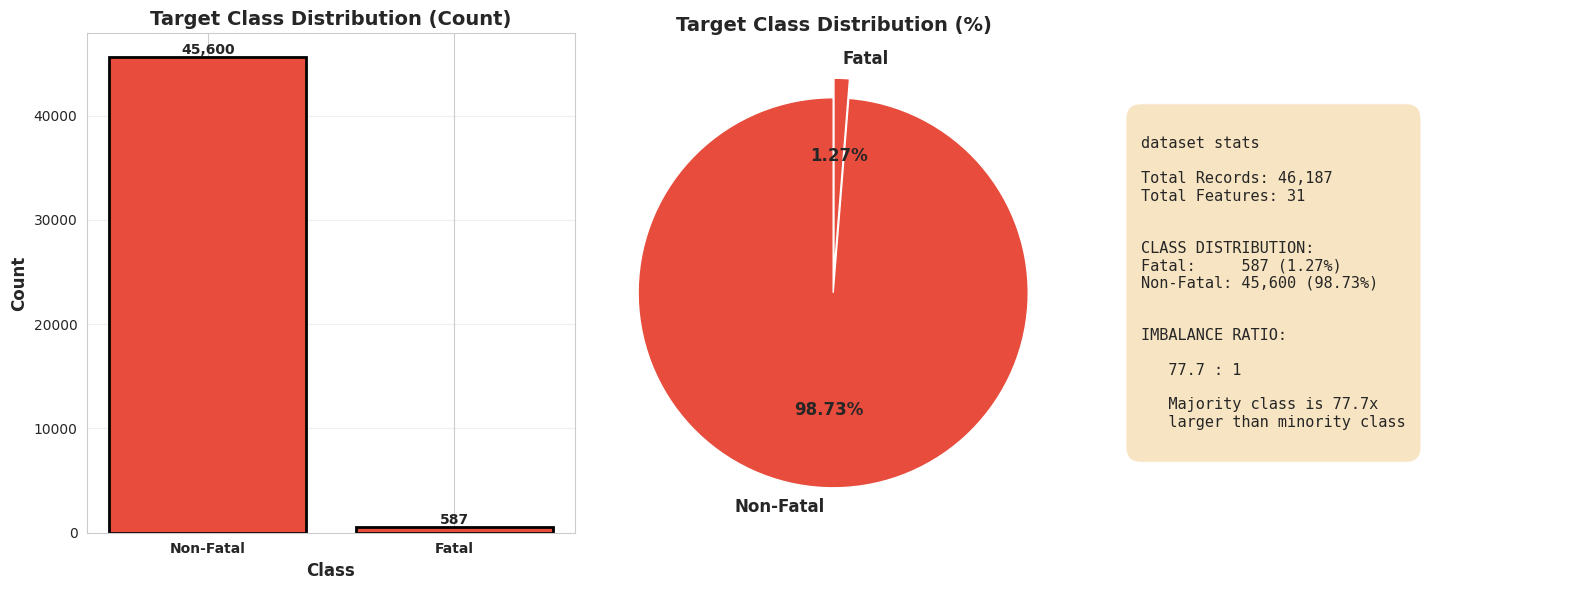


STATISTICAL SUMMARY
            EcNumber          Year         Month          Date  \
count   46187.000000  46187.000000  46187.000000  46187.000000   
mean   157761.723862   2021.432438      6.231017     15.634659   
std    169209.441571      1.066713      3.433947      8.750014   
min         1.000000   2020.000000      1.000000      1.000000   
25%      9051.000000   2021.000000      3.000000      8.000000   
50%     28305.000000   2021.000000      6.000000     16.000000   
75%    348688.500000   2022.000000      9.000000     23.000000   
max    391411.000000   2023.000000     12.000000     31.000000   

       TotalPatientsInEmergency  responsetime  BicycleInvovled  BikesInvolved  \
count              46187.000000  46183.000000     46187.000000   46187.000000   
mean                   1.339619      6.256220         0.008725       0.967242   
std                    0.896699      4.901334         0.093467       0.578776   
min                    1.000000      1.000000         0.0000

In [5]:
target_col = 'ACCLASS' if 'ACCLASS' in df.columns else 'ACC'

fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
counts = df[target_col].value_counts()
colors_bar = ['#e74c3c' if 'Fatal' in str(x) else '#2ecc71' for x in counts.index]
bars = plt.bar(range(len(counts)), counts.values, color=colors_bar, edgecolor='black', linewidth=2)
plt.xticks(range(len(counts)), counts.index, rotation=0, fontweight='bold')
plt.title('Target Class Distribution (Count)', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 3, 2)
colors_pie = ['#e74c3c' if 'Fatal' in str(x) else '#2ecc71' for x in counts.index]
plt.pie(counts.values, labels=counts.index, autopct='%1.2f%%',
        startangle=90, colors=colors_pie, textprops={'fontsize': 12, 'weight': 'bold'},
        explode=[0.05 if 'Fatal' in str(x) else 0 for x in counts.index])
plt.title('Target Class Distribution (%)', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 3)
plt.axis('off')
fatal_count = df[df[target_col].str.contains('Fatal', case=False, na=False) & ~df[target_col].str.contains('Non', case=False, na=False)].shape[0]
non_fatal_count = df[df[target_col].str.contains('Non-Fatal', case=False, na=False)].shape[0]
fatal_pct = (fatal_count / len(df)) * 100
non_fatal_pct = (non_fatal_count / len(df)) * 100
imbalance_ratio = non_fatal_count / fatal_count if fatal_count > 0 else 0

info_text = f"""
dataset stats

Total Records: {len(df):,}
Total Features: {df.shape[1]}


CLASS DISTRIBUTION:
Fatal:     {fatal_count:,} ({fatal_pct:.2f}%)
Non-Fatal: {non_fatal_count:,} ({non_fatal_pct:.2f}%)


IMBALANCE RATIO:

   {imbalance_ratio:.1f} : 1

   Majority class is {imbalance_ratio:.1f}x
   larger than minority class
"""
plt.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=1))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("STATISTICAL SUMMARY")
print("="*70)
print(df.describe())

In [6]:

print("Removing Data Leakage")

df_clean = df.copy()

target_col = 'ACCLASS' if 'ACCLASS' in df.columns else 'ACC'
print(f"\n Target column: {target_col}")

leakage_features = [
    'PatientStatus',
    'InjuryType',
    'EcNumber',
    'CallTime',
    'Date',
    'TotalPatientsInEmergency'
]

leakage_found = [col for col in leakage_features if col in df_clean.columns]

if leakage_found:
    print(f"\nLeakage columns found and removed:")
    for col in leakage_found:
        print(f" {col}")
    df_clean = df_clean.drop(columns=leakage_found)
else:
    print("\n No leakage columns found in dataset")

print(f"\n Dataset shape after removing leakage: {df_clean.shape}")

print("\n" + "-"*70)
print("REMAINING FEATURES (Safe to use):")
print("-"*70)

feature_categories = {
    'TEMPORAL': [],
    'ENVIRONMENTAL': [],
    'DEMOGRAPHIC': [],
    'VEHICLE': [],
    'OTHER': []
}

temporal_keywords = ['year', 'month', 'day', 'time', 'season', 'weekday']
env_keywords = ['light', 'weather']
demo_keywords = ['gender', 'age', 'education']
vehicle_keywords = ['bicycle', 'bike', 'bus', 'car', 'cart', 'rickshaw',
                   'tractor', 'train', 'truck', 'van', 'vehicle', 'involved']

for col in df_clean.columns:
    if col == target_col:
        continue
    col_lower = col.lower()

    if any(kw in col_lower for kw in temporal_keywords):
        feature_categories['TEMPORAL'].append(col)
    elif any(kw in col_lower for kw in env_keywords):
        feature_categories['ENVIRONMENTAL'].append(col)
    elif any(kw in col_lower for kw in demo_keywords) or 'cause' in col_lower or 'response' in col_lower:
        feature_categories['DEMOGRAPHIC'].append(col)
    elif any(kw in col_lower for kw in vehicle_keywords):
        feature_categories['VEHICLE'].append(col)
    else:
        feature_categories['OTHER'].append(col)

total_features = 0
for category, features in feature_categories.items():
    if features:
        print(f"\n{category}:")
        for feat in features:
            print(f"    {feat}")
            total_features += 1

print("\n" + "="*70)
print(f"Total features for modeling: {total_features}")
print(f"Total records: {len(df_clean):,}")
print("="*70)

Removing Data Leakage

 Target column: ACCLASS

Leakage columns found and removed:
 PatientStatus
 InjuryType
 EcNumber
 CallTime
 Date
 TotalPatientsInEmergency

 Dataset shape after removing leakage: (46187, 25)

----------------------------------------------------------------------
REMAINING FEATURES (Safe to use):
----------------------------------------------------------------------

TEMPORAL:
    Year
    Month
    Day
    Nature of Weekday
    Time
    Season
    responsetime

ENVIRONMENTAL:
    Light
    Weather

DEMOGRAPHIC:
    Gender
    Age Range
    EducationTitle
    Cause

VEHICLE:
    BicycleInvovled
    BikesInvolved
    BusesInvolved
    CarsInvolved
    CartInvovled
    RickshawsInvolved
    TractorInvovled
    TrainsInvovled
    TrucksInvolved
    VansInvolved
    OthersInvolved

Total features for modeling: 24
Total records: 46,187


In [7]:
print("Train And Test split")

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"\n Features (X) shape: {X.shape}")
print(f" Target (y) shape: {y.shape}")

print("\n" + "-"*70)
print("splitting the data 80 20")
print("-"*70)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


print("Class Distribution in splits")

print("\n Train set:")
train_dist = y_train.value_counts()
for cls, cnt in train_dist.items():
    pct = (cnt / len(y_train)) * 100
    print(f"   {cls}: {cnt:,} ({pct:.2f}%)")

print("\n Test set:")
test_dist = y_test.value_counts()
for cls, cnt in test_dist.items():
    pct = (cnt / len(y_test)) * 100
    print(f"   {cls}: {cnt:,} ({pct:.2f}%)")


Train And Test split

 Features (X) shape: (46187, 24)
 Target (y) shape: (46187,)

----------------------------------------------------------------------
splitting the data 80 20
----------------------------------------------------------------------

 Training set: 36,949 samples (80.0%)
 Test set:     9,238 samples (20.0%)
Class Distribution in splits

 Train set:
   Non-Fatal: 36,479 (98.73%)
   Fatal: 470 (1.27%)

 Test set:
   Non-Fatal: 9,121 (98.73%)
   Fatal: 117 (1.27%)


In [8]:
print("Data Preprocessing")

print("\n Encode target Variable")

le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print(f"\nClasses: {le_target.classes_}")
print(f"Encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

print("Encode Categorical Features")

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
label_encoders = {}

categorical_cols = X_train.select_dtypes(include=['object']).columns

print(f"\nFound {len(categorical_cols)} categorical columns:")
for col in categorical_cols:
    print(f"   Encoding: {col}")
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_encoded[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"\n Encoded {len(label_encoders)} categorical columns")

print("\n \n Handling missing values")

train_missing = X_train_encoded.isnull().sum(). sum()
test_missing = X_test_encoded.isnull().sum().sum()

if train_missing > 0 or test_missing > 0:
    print(f"\n Missing values found:")
    print(f"  Training set: {train_missing}")
    print(f"  Test set: {test_missing}")
    print("\n   Filling with median...")

    for col in X_train_encoded.columns:
        if X_train_encoded[col].isnull().sum() > 0:
            median_val = X_train_encoded[col].median()
            X_train_encoded[col].fillna(median_val, inplace=True)
            X_test_encoded[col].fillna(median_val, inplace=True)

    print(" Missing values filled")
else:
    print("\n No missing values found")

print(f"   X_train_encoded: {X_train_encoded.shape}")
print(f"   X_test_encoded:  {X_test_encoded.shape}")
print(f"   y_train_encoded: {y_train_encoded.shape}")
print(f"   y_test_encoded:  {y_test_encoded.shape}")

Data Preprocessing

 Encode target Variable

Classes: ['Fatal' 'Non-Fatal']
Encoding: {'Fatal': np.int64(0), 'Non-Fatal': np.int64(1)}
Encode Categorical Features

Found 10 categorical columns:
   Encoding: Day
   Encoding: Nature of Weekday
   Encoding: Time
   Encoding: Season
   Encoding: Light
   Encoding: Weather
   Encoding: Gender
   Encoding: Age Range
   Encoding: EducationTitle
   Encoding: Cause

 Encoded 10 categorical columns

 
 Handling missing values

 Missing values found:
  Training set: 4
  Test set: 0

   Filling with median...
 Missing values filled
   X_train_encoded: (36949, 24)
   X_test_encoded:  (9238, 24)
   y_train_encoded: (36949,)
   y_test_encoded:  (9238,)



 BORDERLINE-SMOTE (sampling_strategy=0.1)

Minority count in training set: 470
Using k_neighbors = 5 for BorderlineSMOTE

Class distribution BEFORE BorderlineSMOTE (train):
  Fatal: 470 (1.27%)
  Non-Fatal: 36,479 (98.73%)

BorderlineSMOTE applied in 0.360s

Class distribution AFTER BorderlineSMOTE (resampled train):
  Fatal: 3,647 (9.09%)
  Non-Fatal: 36,479 (90.91%)

Synthetic minority samples created: 3,177
Training size: 36,949 → 40,126 (+3,177)

Verifying no overlap between original train and test (should be none)...
CRITICAL: Found 484 identical rows between original train and test -> investigate duplicates before training.

Saved: X_train_smote_borderline_0_1.csv and y_train_smote_borderline_0_1.csv


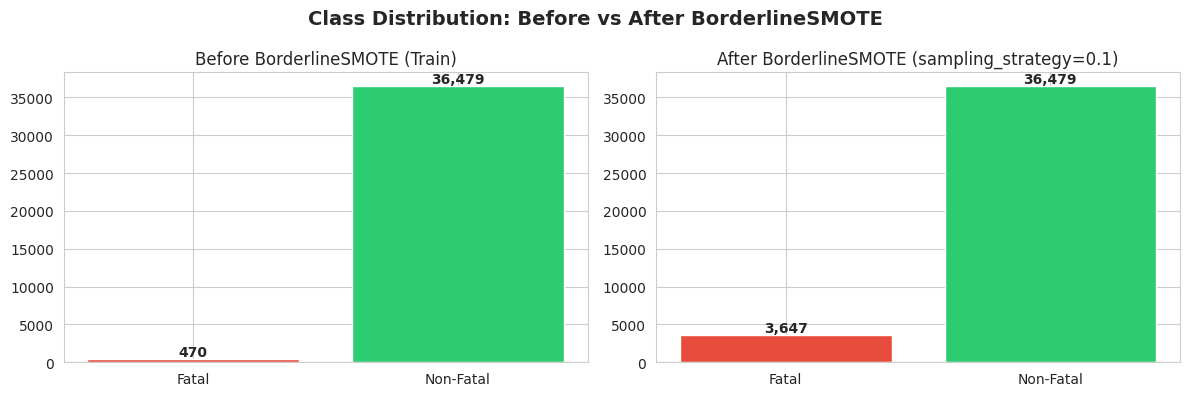

In [9]:

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import BorderlineSMOTE

print("\n BORDERLINE-SMOTE (sampling_strategy=0.1)")


required_vars = ['X_train_encoded', 'y_train_encoded', 'X_test_encoded', 'y_test_encoded', 'le_target']
for v in required_vars:
    if v not in globals():
        raise NameError(f"Required variable '{v}' not found. Run preprocessing cell first.")

counts = np.bincount(y_train_encoded)
minority_count = counts.min()
k_neighbors = min(5, max(1, minority_count - 1))
print(f"\nMinority count in training set: {minority_count:,}")
print(f"Using k_neighbors = {k_neighbors} for BorderlineSMOTE\n")

sampling_strategy = 0.1
sampler = BorderlineSMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)

unique_before, counts_before = np.unique(y_train_encoded, return_counts=True)
print("="*60)
print("Class distribution BEFORE BorderlineSMOTE (train):")
for cls_idx, cnt in zip(unique_before, counts_before):
    print(f"  {le_target.inverse_transform([cls_idx])[0]}: {cnt:,} ({cnt/len(y_train_encoded)*100:.2f}%)")
print("="*60)

t0 = time.time()
X_resampled, y_resampled = sampler.fit_resample(X_train_encoded, y_train_encoded)
t_elapsed = time.time() - t0
print(f"\nBorderlineSMOTE applied in {t_elapsed:.3f}s")

if isinstance(X_resampled, np.ndarray):
    X_train_smote = pd.DataFrame(X_resampled, columns=X_train_encoded.columns)
else:
    X_train_smote = X_resampled.copy()
y_train_smote = pd.Series(y_resampled, name='Target')

unique_after, counts_after = np.unique(y_train_smote, return_counts=True)
print("\nClass distribution AFTER BorderlineSMOTE (resampled train):")
for cls_idx, cnt in zip(unique_after, counts_after):
    print(f"  {le_target.inverse_transform([cls_idx])[0]}: {cnt:,} ({cnt/len(y_train_smote)*100:.2f}%)")

synthetic_created = counts_after.min() - counts_before.min()
print(f"\nSynthetic minority samples created: {synthetic_created:,}")
print(f"Training size: {len(y_train_encoded):,} → {len(y_train_smote):,} (+{len(y_train_smote)-len(y_train_encoded):,})")
print("="*60)

print("\nVerifying no overlap between original train and test (should be none)...")
X_train_check = X_train_encoded.reset_index(drop=True)
X_test_check = X_test_encoded.reset_index(drop=True)

train_hash = set(pd.util.hash_pandas_object(X_train_check, index=False))
test_hash = set(pd.util.hash_pandas_object(X_test_check, index=False))
overlap_hash = train_hash.intersection(test_hash)
if len(overlap_hash) > 0:
    print(f"WARNING: Detected {len(overlap_hash)} hash overlaps between original train and test (possible duplicates).")
    merged = X_train_check.merge(X_test_check, how='inner')
    if len(merged) > 0:
        print(f"CRITICAL: Found {len(merged)} identical rows between original train and test -> investigate duplicates before training.")
    else:
        print("Hash collisions only (no exact identical rows found).")
else:
    print("No overlap detected between original train and test. OK.")

X_train_smote.to_csv('X_train_smote_borderline_0_1.csv', index=False)
y_train_smote.to_csv('y_train_smote_borderline_0_1.csv', index=False)
print("\nSaved: X_train_smote_borderline_0_1.csv and y_train_smote_borderline_0_1.csv")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# before
labels_before = [le_target.inverse_transform([i])[0] for i in unique_before]
axes[0].bar(labels_before, counts_before, color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Before BorderlineSMOTE (Train)')
for i, v in enumerate(counts_before):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
# after
labels_after = [le_target.inverse_transform([i])[0] for i in unique_after]
axes[1].bar(labels_after, counts_after, color=['#e74c3c', '#2ecc71'])
axes[1].set_title(f'After BorderlineSMOTE (sampling_strategy={sampling_strategy})')
for i, v in enumerate(counts_after):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Class Distribution: Before vs After BorderlineSMOTE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Random Forest Model 1

Training Configuration:
Total samples: 40,126
Fatal: 3,647 (9.09%)
Non-Fatal: 36,479 (90.91%)
Class weight (Fatal): 10.00

Training model...
Training completed in 22.58 seconds
Out-of-Bag Score: 0.9846

Making predictions and optimizing threshold...
Optimal threshold: 0.246
Results at Threshold = 0.246

Key Metrics:
Fatal cases caught: 67/117 (57.3%)
Fatal cases missed: 50/117 (42.7%)
False alarms: 642/9,121 (7.0%)
Precision: 9.45%
F1-Score: 16.22%
Overall Accuracy: 92.51%
ROC-AUC: 0.8350

Confusion Matrix:
              Predicted
              Fatal  Non-Fatal
Actual Fatal     67       50
       Non-Fatal642     8479

 Top 10 contributing factors

 1. BikesInvolved                  23.20%
 2. responsetime                   18.07%
 3. TrucksInvolved                  7.86%
 4. EducationTitle                  7.79%
 5. Time                            5.15%
 6. Month                           5.09%
 7. Day                             4.39%
 8. Year                  

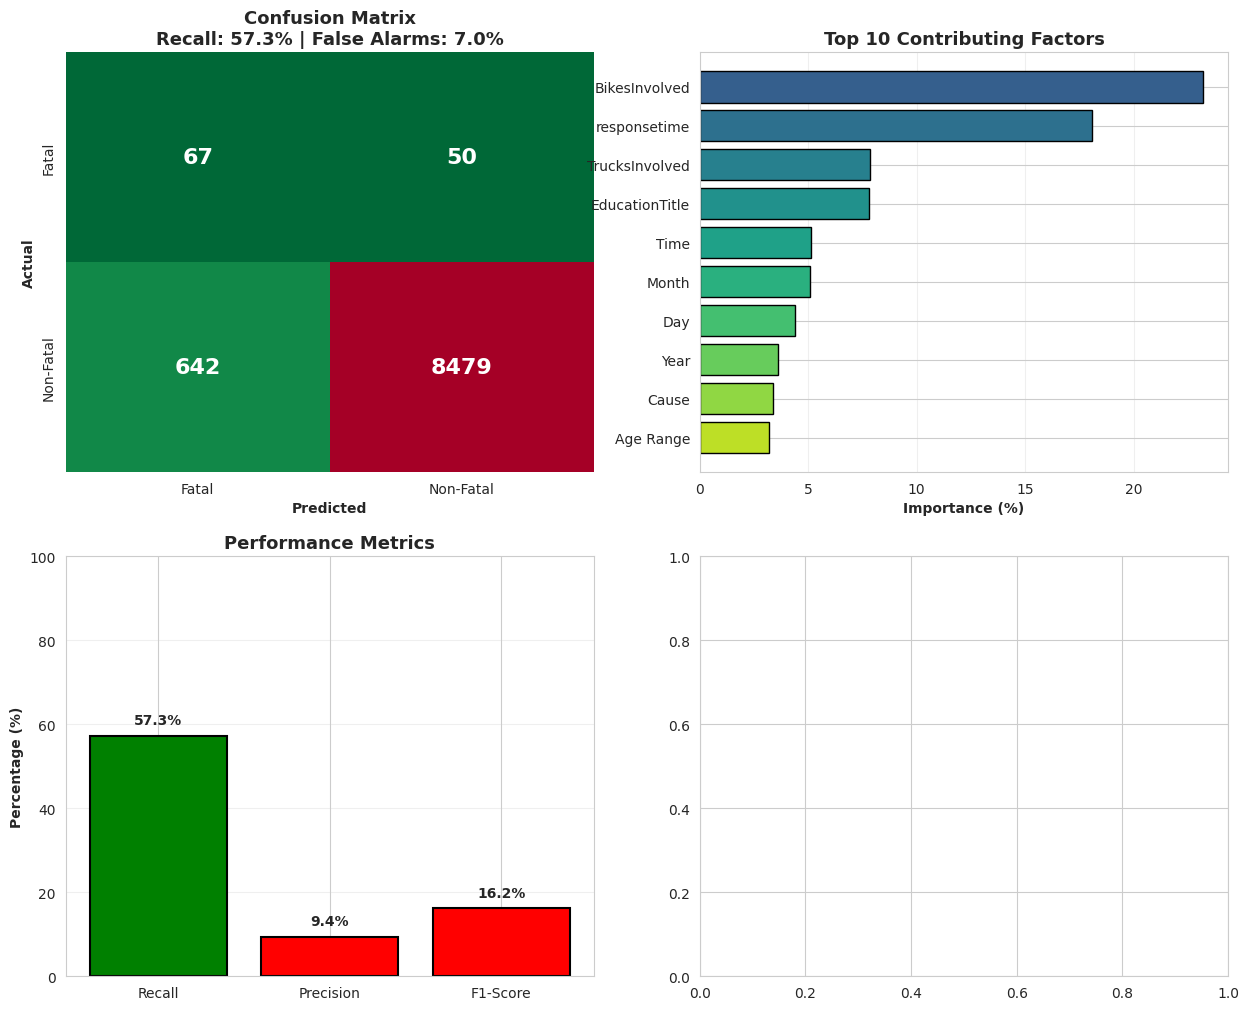

In [13]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print("Random Forest Model 1")


required_vars = ['X_train_smote', 'y_train_smote', 'X_test_encoded', 'y_test_encoded', 'le_target']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Required variables not found: {missing}. Run preprocessing first.")

MODEL_FILENAME = "rf_practical_model.pkl"
METRICS_CSV = "rf_practical_metrics.csv"
PLOTS_FILENAME = "rf_practical_analysis.png"

N_ESTIMATORS = 500
MAX_DEPTH = 15
MIN_SAMPLES_SPLIT = 10
MIN_SAMPLES_LEAF = 4
MAX_FEATURES = 'sqrt'
RANDOM_STATE = 42

fatal_label = int(le_target.transform(['Fatal'])[0])
non_fatal_label = int(le_target.transform(['Non-Fatal'])[0])

counts = Counter(y_train_smote)
pos = counts.get(fatal_label, 0)
neg = counts.get(non_fatal_label, 0)
total = sum(counts.values())

class_weight_ratio = neg / pos
class_weights = {non_fatal_label: 1.0, fatal_label: class_weight_ratio}

print(f"\nTraining Configuration:")
print(f"Total samples: {total:,}")
print(f"Fatal: {pos:,} ({pos/total*100:.2f}%)")
print(f"Non-Fatal: {neg:,} ({neg/total*100:.2f}%)")
print(f"Class weight (Fatal): {class_weight_ratio:.2f}")

rf_model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    max_features=MAX_FEATURES,
    class_weight=class_weights,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

print("\nTraining model...")
t0 = time.time()
rf_model.fit(X_train_smote, y_train_smote)
train_time = time.time() - t0
print(f"Training completed in {train_time:.2f} seconds")
print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}")

print("\nMaking predictions and optimizing threshold...")
proba = rf_model.predict_proba(X_test_encoded)
fatal_idx = list(rf_model.classes_).index(fatal_label)
y_proba_fatal = proba[:, fatal_idx]
y_true_bin = (y_test_encoded == fatal_label).astype(int)


thresholds = np.linspace(0.01, 0.95, 200)
best_threshold = None
best_score = -1

for t in thresholds:
    y_pred_t = (y_proba_fatal >= t).astype(int)
    rec = recall_score(y_true_bin, y_pred_t, zero_division=0)
    prec = precision_score(y_true_bin, y_pred_t, zero_division=0)

    cm_temp = confusion_matrix(y_true_bin, y_pred_t)
    false_alarms = cm_temp[0, 1] if cm_temp.shape[0] > 1 else 0
    false_alarm_rate = false_alarms / (cm_temp[0, 0] + cm_temp[0, 1]) if (cm_temp[0, 0] + cm_temp[0, 1]) > 0 else 0

    # Prioritize recall while keeping false alarms manageable
    if rec >= 0.30 and false_alarm_rate <= 0.15:
        score = rec * prec * 100
        if score > best_score:
            best_score = score
            best_threshold = t

if best_threshold is None:
    print("No threshold meets strict criteria, using best F1...")
    f1_scores = []
    for t in thresholds:
        y_pred_t = (y_proba_fatal >= t).astype(int)
        f1 = f1_score(y_true_bin, y_pred_t, zero_division=0)
        f1_scores.append(f1)
    best_threshold = thresholds[np.argmax(f1_scores)]

OPTIMAL_THRESHOLD = best_threshold

print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.3f}")

print(f"Results at Threshold = {OPTIMAL_THRESHOLD:.3f}")


y_pred = (y_proba_fatal >= OPTIMAL_THRESHOLD).astype(int)
y_pred_labels = np.where(y_pred == 1, fatal_label, non_fatal_label)

cm = confusion_matrix(y_test_encoded, y_pred_labels)
accuracy = accuracy_score(y_test_encoded, y_pred_labels)
precision = precision_score(y_true_bin, y_pred, zero_division=0)
recall = recall_score(y_true_bin, y_pred, zero_division=0)
f1 = f1_score(y_true_bin, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true_bin, y_proba_fatal)

fatal_caught = cm[0, 0]
fatal_missed = cm[0, 1]
false_alarms = cm[1, 0]
total_fatal = fatal_caught + fatal_missed
false_alarm_rate = false_alarms / 9121

print(f"\nKey Metrics:")
print(f"Fatal cases caught: {fatal_caught}/{total_fatal} ({recall*100:.1f}%)")
print(f"Fatal cases missed: {fatal_missed}/{total_fatal} ({(fatal_missed/total_fatal)*100:.1f}%)")
print(f"False alarms: {false_alarms}/9,121 ({false_alarm_rate*100:.1f}%)")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(f"              Predicted")
print(f"              Fatal  Non-Fatal")
print(f"Actual Fatal    {cm[0,0]:3d}      {cm[0,1]:3d}")
print(f"       Non-Fatal{cm[1,0]:3d}     {cm[1,1]:4d}")

print("\n Top 10 contributing factors")


feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print()
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<30} {row['Importance']*100:5.2f}%")

print(f"\nTop 3 factors account for {feature_importance.head(3)['Importance'].sum()*100:.1f}% of predictions")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False,
            xticklabels=['Fatal', 'Non-Fatal'], yticklabels=['Fatal', 'Non-Fatal'],
            ax=axes[0, 0], annot_kws={"size": 16, "weight": "bold"})
axes[0, 0].set_title(f'Confusion Matrix\nRecall: {recall*100:.1f}% | False Alarms: {false_alarm_rate*100:.1f}%',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontweight='bold')
axes[0, 0].set_xlabel('Predicted', fontweight='bold')

top10 = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top10)))
axes[0, 1].barh(range(len(top10)), top10['Importance']*100, color=colors, edgecolor='black')
axes[0, 1].set_yticks(range(len(top10)))
axes[0, 1].set_yticklabels(top10['Feature'])
axes[0, 1].set_xlabel('Importance (%)', fontweight='bold')
axes[0, 1].set_title('Top 10 Contributing Factors', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

metrics_names = ['Recall', 'Precision', 'F1-Score']
metrics_values = [recall*100, precision*100, f1*100]
colors_metrics = ['green' if v >= 30 else 'orange' if v >= 20 else 'red' for v in metrics_values]
bars = axes[1, 0].bar(metrics_names, metrics_values, color=colors_metrics, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Percentage (%)', fontweight='bold')
axes[1, 0].set_title('Performance Metrics', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

joblib.dump(rf_model, MODEL_FILENAME)
print(f"\nModel saved to: {MODEL_FILENAME}")

summary = pd.DataFrame({
    'Model': ['Random Forest'],
    'Threshold': [OPTIMAL_THRESHOLD],
    'Training_Time': [train_time],
    'Fatal_Caught': [fatal_caught],
    'Total_Fatal': [total_fatal],
    'Recall': [recall*100],
    'Precision': [precision*100],
    'F1_Score': [f1*100],
    'False_Alarms': [false_alarms],
    'False_Alarm_Rate': [false_alarm_rate*100],
    'Accuracy': [accuracy*100],
    'ROC_AUC': [roc_auc],
    'OOB_Score': [rf_model.oob_score_]
})
summary.to_csv(METRICS_CSV, index=False)
print(f"Metrics saved to: {METRICS_CSV}")

feature_importance.head(10).to_csv('rf_top10_features.csv', index=False)
print(f"Top features saved to: rf_top10_features.csv")

print("DEPLOYMENT SUMMARY")
print(f"\nModel: Random Forest")
print(f"Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"Fatal recall: {recall*100:.1f}% ({fatal_caught}/117 lives potentially saved)")
print(f"False alarm rate: {false_alarm_rate*100:.1f}% ({false_alarms}/9,121)")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"Training time: {train_time:.1f}s")


XGBoost Model 2

Training Configuration:
Total samples: 40,126
Fatal: 3,647 (9.09%)
Non-Fatal: 36,479 (90.91%)
scale_pos_weight: 10.00

Training model...
Training completed in 7.23 seconds

Making predictions and optimizing threshold...
Optimal threshold: 0.024

Results at Threshold = 0.024

Key Metrics:
Fatal cases caught: 40/117 (34.2%)
Fatal cases missed: 77/117 (65.8%)
False alarms: 257/9,121 (2.8%)
Precision: 13.47%
F1-Score: 19.32%
Overall Accuracy: 96.38%
ROC-AUC: 0.8264

Deployment assessment: Good - Deployable with monitoring

Confusion Matrix:
              Predicted
              Fatal  Non-Fatal
Actual Fatal     40       77
       Non-Fatal257     8864

Top 10 Contributing Factors:

 1. BikesInvolved                  12.90%
 2. RickshawsInvolved              10.98%
 3. VansInvolved                    8.87%
 4. TrainsInvovled                  6.57%
 5. BicycleInvovled                 6.53%
 6. CarsInvolved                    6.50%
 7. TrucksInvolved                  6.38%
 8

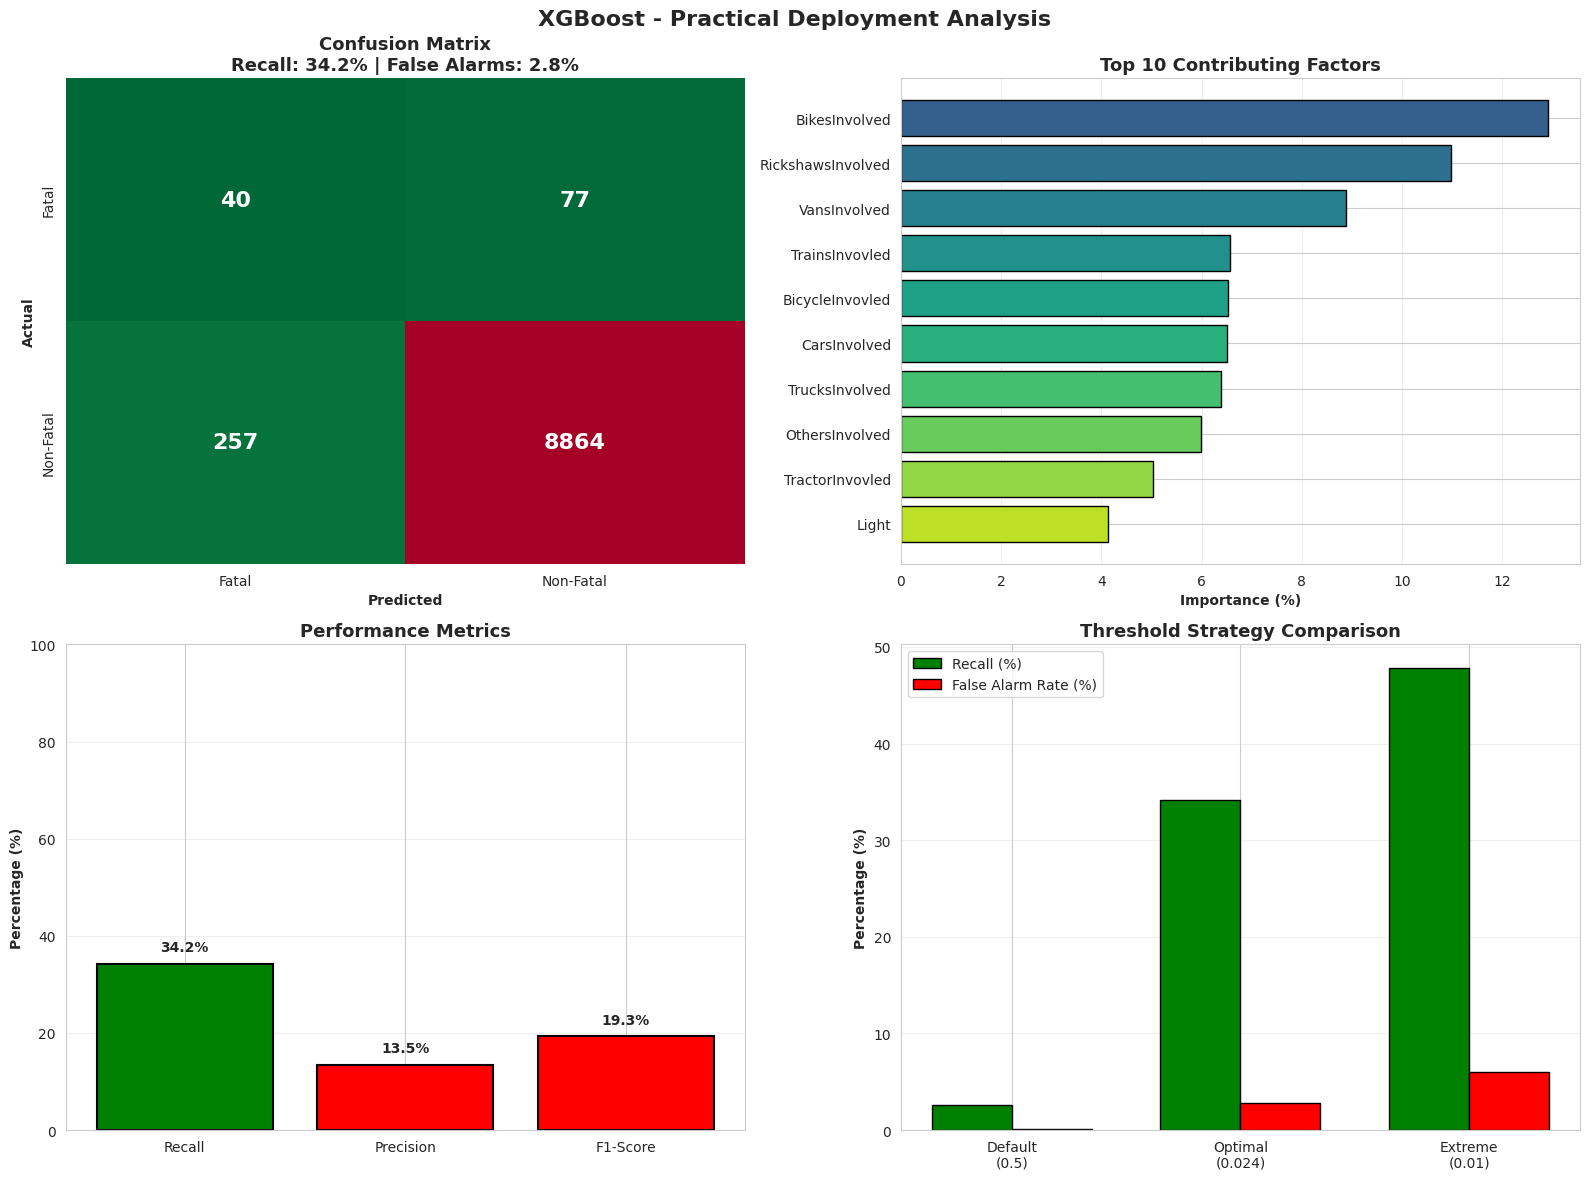


Model saved to: xgb_practical_model.pkl
Metrics saved to: xgb_practical_metrics.csv
Top features saved to: xgb_top10_features.csv

Deployment Summary:
Model: XGBoost
Threshold: 0.024
Fatal recall: 34.2% (40/117)
False alarm rate: 2.8% (257/9,121)
Precision: 13.47%
F1-Score: 19.32%
Training time: 7.2s
Assessment: Good - Deployable with monitoring

Top 3 risk factors:
1. BikesInvolved: 12.90%
2. RickshawsInvolved: 10.98%
3. VansInvolved: 8.87%


In [16]:
import xgboost as xgb
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print("XGBoost Model 2")

required_vars = ['X_train_smote', 'y_train_smote', 'X_test_encoded', 'y_test_encoded', 'le_target']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Required variables not found: {missing}. Run preprocessing first.")

MODEL_FILENAME = "xgb_practical_model.pkl"
METRICS_CSV = "xgb_practical_metrics.csv"
PLOTS_FILENAME = "xgb_practical_analysis.png"

N_ESTIMATORS = 300
LEARNING_RATE = 0.03
MAX_DEPTH = 7
MIN_CHILD_WEIGHT = 3
GAMMA = 0.1
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8
RANDOM_STATE = 42

fatal_label = int(le_target.transform(['Fatal'])[0])
non_fatal_label = int(le_target.transform(['Non-Fatal'])[0])

counts = Counter(y_train_smote)
pos = counts.get(fatal_label, 0)
neg = counts.get(non_fatal_label, 0)
total = sum(counts.values())

if pos == 0:
    raise ValueError("No Fatal samples in y_train_smote. Cannot train.")

scale_pos_weight = float(neg) / float(pos)

print(f"\nTraining Configuration:")
print(f"Total samples: {total:,}")
print(f"Fatal: {pos:,} ({pos/total*100:.2f}%)")
print(f"Non-Fatal: {neg:,} ({neg/total*100:.2f}%)")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=N_ESTIMATORS,
    learning_rate=LEARNING_RATE,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    subsample=SUBSAMPLE,
    colsample_bytree=COLSAMPLE_BYTREE,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    tree_method='hist'
)

print("\nTraining model...")
t0 = time.time()
xgb_model.fit(X_train_smote, y_train_smote)
train_time = time.time() - t0
print(f"Training completed in {train_time:.2f} seconds")

print("\nMaking predictions and optimizing threshold...")
proba = xgb_model.predict_proba(X_test_encoded)
fatal_idx = list(xgb_model.classes_).index(fatal_label)
y_proba_fatal = proba[:, fatal_idx]
y_true_bin = (y_test_encoded == fatal_label).astype(int)

thresholds = np.linspace(0.01, 0.95, 200)
best_threshold = None
best_score = -1

for t in thresholds:
    y_pred_t = (y_proba_fatal >= t).astype(int)
    rec = recall_score(y_true_bin, y_pred_t, zero_division=0)
    prec = precision_score(y_true_bin, y_pred_t, zero_division=0)

    cm_temp = confusion_matrix(y_true_bin, y_pred_t)
    false_alarms = cm_temp[0, 1] if cm_temp.shape[0] > 1 else 0
    false_alarm_rate = false_alarms / (cm_temp[0, 0] + cm_temp[0, 1]) if (cm_temp[0, 0] + cm_temp[0, 1]) > 0 else 0

    if rec >= 0.30 and false_alarm_rate <= 0.15:
        score = rec * prec * 100
        if score > best_score:
            best_score = score
            best_threshold = t

if best_threshold is None:
    print("No threshold meets criteria, using best F1...")
    f1_scores = []
    for t in thresholds:
        y_pred_t = (y_proba_fatal >= t).astype(int)
        f1 = f1_score(y_true_bin, y_pred_t, zero_division=0)
        f1_scores.append(f1)
    best_threshold = thresholds[np.argmax(f1_scores)]

OPTIMAL_THRESHOLD = best_threshold

print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.3f}")

print(f"\nResults at Threshold = {OPTIMAL_THRESHOLD:.3f}")

y_pred = (y_proba_fatal >= OPTIMAL_THRESHOLD).astype(int)
y_pred_labels = np.where(y_pred == 1, fatal_label, non_fatal_label)

cm = confusion_matrix(y_test_encoded, y_pred_labels)
accuracy = accuracy_score(y_test_encoded, y_pred_labels)
precision = precision_score(y_true_bin, y_pred, zero_division=0)
recall = recall_score(y_true_bin, y_pred, zero_division=0)
f1 = f1_score(y_true_bin, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true_bin, y_proba_fatal)

fatal_caught = cm[0, 0]
fatal_missed = cm[0, 1]
false_alarms = cm[1, 0]
total_fatal = fatal_caught + fatal_missed
false_alarm_rate = false_alarms / 9121

print(f"\nKey Metrics:")
print(f"Fatal cases caught: {fatal_caught}/{total_fatal} ({recall*100:.1f}%)")
print(f"Fatal cases missed: {fatal_missed}/{total_fatal} ({(fatal_missed/total_fatal)*100:.1f}%)")
print(f"False alarms: {false_alarms}/9,121 ({false_alarm_rate*100:.1f}%)")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"ROC-AUC: {roc_auc:.4f}")

if recall >= 0.40 and false_alarm_rate <= 0.10:
    usability = "Excellent - Highly deployable"
elif recall >= 0.30 and false_alarm_rate <= 0.15:
    usability = "Good - Deployable with monitoring"
elif recall >= 0.20 and false_alarm_rate <= 0.20:
    usability = "Fair - Requires oversight"
else:
    usability = "Poor - Not recommended"

print(f"\nDeployment assessment: {usability}")

print("\nConfusion Matrix:")
print(f"              Predicted")
print(f"              Fatal  Non-Fatal")
print(f"Actual Fatal    {cm[0,0]:3d}      {cm[0,1]:3d}")
print(f"       Non-Fatal{cm[1,0]:3d}     {cm[1,1]:4d}")

print("\nTop 10 Contributing Factors:")

feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print()
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<30} {row['Importance']*100:5.2f}%")

print(f"\nTop 3 factors account for {feature_importance.head(3)['Importance'].sum()*100:.1f}% of predictions")

print("\nThreshold Comparison:")

y_pred_default = (y_proba_fatal >= 0.5).astype(int)
cm_default = confusion_matrix(y_true_bin, y_pred_default)
rec_default = recall_score(y_true_bin, y_pred_default, zero_division=0)
prec_default = precision_score(y_true_bin, y_pred_default, zero_division=0)
f1_default = f1_score(y_true_bin, y_pred_default, zero_division=0)
caught_default = cm_default[1, 1] if cm_default.shape[0] > 1 else 0
fa_default = cm_default[0, 1] if cm_default.shape[0] > 1 else 0

y_pred_extreme = (y_proba_fatal >= 0.01).astype(int)
cm_extreme = confusion_matrix(y_true_bin, y_pred_extreme)
rec_extreme = recall_score(y_true_bin, y_pred_extreme, zero_division=0)
prec_extreme = precision_score(y_true_bin, y_pred_extreme, zero_division=0)
f1_extreme = f1_score(y_true_bin, y_pred_extreme, zero_division=0)
caught_extreme = cm_extreme[1, 1] if cm_extreme.shape[0] > 1 else 0
fa_extreme = cm_extreme[0, 1] if cm_extreme.shape[0] > 1 else 0

print(f"\n{'Threshold':<15} {'Caught':<10} {'Recall':<10} {'Precision':<12} {'F1':<10} {'False Alarms'}")
print("-" * 70)
print(f"0.500 (default) {caught_default:>3}/117   {rec_default*100:>5.1f}%    {prec_default*100:>7.2f}%     {f1_default*100:>5.2f}%   {fa_default:>4} ({fa_default/9121*100:.1f}%)")
print(f"{OPTIMAL_THRESHOLD:.3f} (optimal){fatal_caught:>3}/117   {recall*100:>5.1f}%    {precision*100:>7.2f}%     {f1*100:>5.2f}%   {false_alarms:>4} ({false_alarm_rate*100:.1f}%)")
print(f"0.010 (extreme) {caught_extreme:>3}/117   {rec_extreme*100:>5.1f}%    {prec_extreme*100:>7.2f}%     {f1_extreme*100:>5.2f}%   {fa_extreme:>4} ({fa_extreme/9121*100:.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False,
            xticklabels=['Fatal', 'Non-Fatal'], yticklabels=['Fatal', 'Non-Fatal'],
            ax=axes[0, 0], annot_kws={"size": 16, "weight": "bold"})
axes[0, 0].set_title(f'Confusion Matrix\nRecall: {recall*100:.1f}% | False Alarms: {false_alarm_rate*100:.1f}%',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontweight='bold')
axes[0, 0].set_xlabel('Predicted', fontweight='bold')

top10 = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top10)))
axes[0, 1].barh(range(len(top10)), top10['Importance']*100, color=colors, edgecolor='black')
axes[0, 1].set_yticks(range(len(top10)))
axes[0, 1].set_yticklabels(top10['Feature'])
axes[0, 1].set_xlabel('Importance (%)', fontweight='bold')
axes[0, 1].set_title('Top 10 Contributing Factors', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

metrics_names = ['Recall', 'Precision', 'F1-Score']
metrics_values = [recall*100, precision*100, f1*100]
colors_metrics = ['green' if v >= 30 else 'orange' if v >= 20 else 'red' for v in metrics_values]
bars = axes[1, 0].bar(metrics_names, metrics_values, color=colors_metrics, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Percentage (%)', fontweight='bold')
axes[1, 0].set_title('Performance Metrics', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

threshold_names = ['Default\n(0.5)', f'Optimal\n({OPTIMAL_THRESHOLD:.3f})', 'Extreme\n(0.01)']
recalls = [rec_default*100, recall*100, rec_extreme*100]
fa_rates = [fa_default/9121*100, false_alarm_rate*100, fa_extreme/9121*100]

x = np.arange(len(threshold_names))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, recalls, width, label='Recall (%)',
                       color='green', edgecolor='black')
bars2 = axes[1, 1].bar(x + width/2, fa_rates, width, label='False Alarm Rate (%)',
                       color='red', edgecolor='black')

axes[1, 1].set_ylabel('Percentage (%)', fontweight='bold')
axes[1, 1].set_title('Threshold Strategy Comparison', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(threshold_names)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('XGBoost - Practical Deployment Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_FILENAME, dpi=300, bbox_inches='tight')
plt.show()

joblib.dump(xgb_model, MODEL_FILENAME)
print(f"\nModel saved to: {MODEL_FILENAME}")

summary = pd.DataFrame({
    'Model': ['XGBoost'],
    'Threshold': [OPTIMAL_THRESHOLD],
    'Training_Time': [train_time],
    'Fatal_Caught': [fatal_caught],
    'Total_Fatal': [total_fatal],
    'Recall': [recall*100],
    'Precision': [precision*100],
    'F1_Score': [f1*100],
    'False_Alarms': [false_alarms],
    'False_Alarm_Rate': [false_alarm_rate*100],
    'Accuracy': [accuracy*100],
    'ROC_AUC': [roc_auc]
})
summary.to_csv(METRICS_CSV, index=False)
print(f"Metrics saved to: {METRICS_CSV}")

feature_importance.head(10).to_csv('xgb_top10_features.csv', index=False)
print(f"Top features saved to: xgb_top10_features.csv")

print("\nDeployment Summary:")
print(f"Model: XGBoost")
print(f"Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"Fatal recall: {recall*100:.1f}% ({fatal_caught}/117)")
print(f"False alarm rate: {false_alarm_rate*100:.1f}% ({false_alarms}/9,121)")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"Training time: {train_time:.1f}s")
print(f"Assessment: {usability}")

print(f"\nTop 3 risk factors:")
for i, (idx, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']*100:.2f}%")

ANN Model 3

Training Configuration:
Total samples: 40,126
Fatal: 3,647 (9.09%)
Non-Fatal: 36,479 (90.91%)
Class weight ratio: 10.00

Creating balanced training set for ANN...
Original training size: 40,126
Balanced training size: 47,420
Fatal samples: 10,941 (23.07%)

Scaling features...
Feature scaling completed

Training model...
Training completed in 134.98 seconds
Converged: True
Iterations: 67
Final Loss: 0.017955

Making predictions and optimizing threshold...
Optimal threshold: 0.010

Results at Threshold = 0.010

Key Metrics:
Fatal cases caught: 38/117 (32.5%)
Fatal cases missed: 79/117 (67.5%)
False alarms: 264/9,121 (2.9%)
Precision: 12.58%
F1-Score: 18.14%
Overall Accuracy: 96.29%
ROC-AUC: 0.8064

Deployment assessment: Good - Deployable with monitoring

Confusion Matrix:
              Predicted
              Fatal  Non-Fatal
Actual Fatal     38       79
       Non-Fatal264     8857

Calculating feature importance...

Top 10 Contributing Factors:
 1. BikesInvolved          

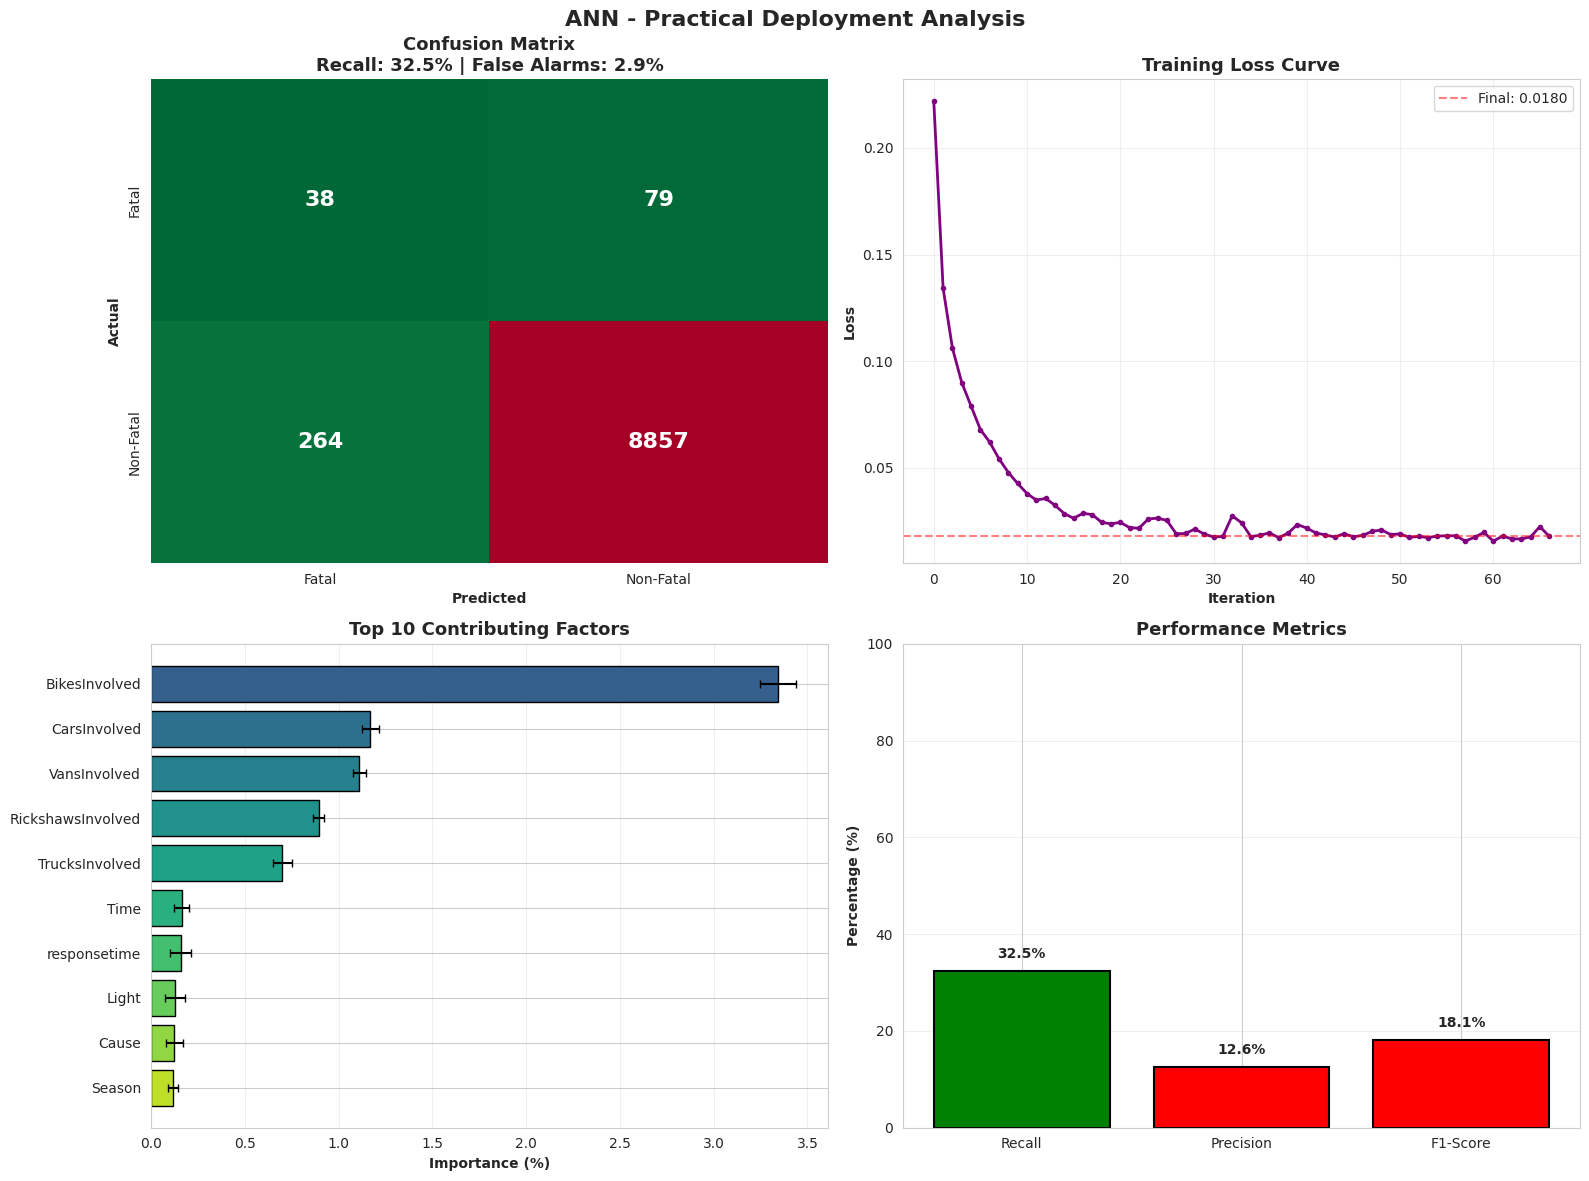


Model saved to: ann_practical_model.pkl
Scaler saved to: ann_scaler.pkl
Metrics saved to: ann_practical_metrics.csv
Feature importance saved to: ann_feature_importance.csv

Deployment Summary:
Model: ANN
Threshold: 0.010
Fatal recall: 32.5% (38/117)
False alarm rate: 2.9% (264/9,121)
Precision: 12.58%
F1-Score: 18.14%
Training time: 135.0s
Assessment: Good - Deployable with monitoring

Top 3 risk factors:
1. BikesInvolved: 3.34% (std: 0.10%)
2. CarsInvolved: 1.17% (std: 0.05%)
3. VansInvolved: 1.11% (std: 0.04%)


In [17]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print("ANN Model 3")

required_vars = ['X_train_smote', 'y_train_smote', 'X_test_encoded', 'y_test_encoded', 'le_target']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Required variables not found: {missing}. Run preprocessing first.")

MODEL_FILENAME = "ann_practical_model.pkl"
SCALER_FILENAME = "ann_scaler.pkl"
METRICS_CSV = "ann_practical_metrics.csv"
FEATURE_IMPORTANCE_CSV = "ann_feature_importance.csv"
PLOTS_FILENAME = "ann_practical_analysis.png"

HIDDEN_LAYERS = (256, 128, 64, 32)
ACTIVATION = 'relu'
SOLVER = 'adam'
MAX_ITER = 500
LEARNING_RATE = 0.001
ALPHA = 0.01
BATCH_SIZE = 256
EARLY_STOPPING = True
VALIDATION_FRACTION = 0.15
RANDOM_STATE = 42

fatal_label = int(le_target.transform(['Fatal'])[0])
non_fatal_label = int(le_target.transform(['Non-Fatal'])[0])

counts = Counter(y_train_smote)
pos = counts.get(fatal_label, 0)
neg = counts.get(non_fatal_label, 0)
total = sum(counts.values())

if pos == 0:
    raise ValueError("No Fatal samples in y_train_smote. Cannot train.")

class_weight_ratio = neg / pos

print(f"\nTraining Configuration:")
print(f"Total samples: {total:,}")
print(f"Fatal: {pos:,} ({pos/total*100:.2f}%)")
print(f"Non-Fatal: {neg:,} ({neg/total*100:.2f}%)")
print(f"Class weight ratio: {class_weight_ratio:.2f}")

print(f"\nCreating balanced training set for ANN...")
fatal_mask = (y_train_smote == fatal_label)
X_fatal = X_train_smote[fatal_mask]
y_fatal = y_train_smote[fatal_mask]

n_duplicates = 2
X_fatal_augmented = pd.concat([X_fatal] * n_duplicates, ignore_index=True)
y_fatal_augmented = pd.concat([y_fatal] * n_duplicates, ignore_index=True)

X_train_balanced = pd.concat([X_train_smote, X_fatal_augmented], ignore_index=True)
y_train_balanced = pd.concat([y_train_smote, y_fatal_augmented], ignore_index=True)

shuffle_idx = np.random.RandomState(RANDOM_STATE).permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced.iloc[shuffle_idx].reset_index(drop=True)
y_train_balanced = y_train_balanced.iloc[shuffle_idx].reset_index(drop=True)

print(f"Original training size: {len(X_train_smote):,}")
print(f"Balanced training size: {len(X_train_balanced):,}")
print(f"Fatal samples: {(y_train_balanced == fatal_label).sum():,} ({(y_train_balanced == fatal_label).sum()/len(y_train_balanced)*100:.2f}%)")

print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_encoded)
print("Feature scaling completed")

ann_model = MLPClassifier(
    hidden_layer_sizes=HIDDEN_LAYERS,
    activation=ACTIVATION,
    solver=SOLVER,
    alpha=ALPHA,
    batch_size=BATCH_SIZE,
    learning_rate='adaptive',
    learning_rate_init=LEARNING_RATE,
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE,
    early_stopping=EARLY_STOPPING,
    validation_fraction=VALIDATION_FRACTION,
    n_iter_no_change=20,
    tol=1e-4,
    verbose=False
)

print("\nTraining model...")
t0 = time.time()
ann_model.fit(X_train_scaled, y_train_balanced)
train_time = time.time() - t0

print(f"Training completed in {train_time:.2f} seconds")
print(f"Converged: {ann_model.n_iter_ < MAX_ITER}")
print(f"Iterations: {ann_model.n_iter_}")
print(f"Final Loss: {ann_model.loss_:.6f}")

print("\nMaking predictions and optimizing threshold...")
proba = ann_model.predict_proba(X_test_scaled)
fatal_idx = list(ann_model.classes_).index(fatal_label)
y_proba_fatal = proba[:, fatal_idx]
y_true_bin = (y_test_encoded == fatal_label).astype(int)

thresholds = np.linspace(0.01, 0.95, 200)
best_threshold = None
best_score = -1

for t in thresholds:
    y_pred_t = (y_proba_fatal >= t).astype(int)
    rec = recall_score(y_true_bin, y_pred_t, zero_division=0)
    prec = precision_score(y_true_bin, y_pred_t, zero_division=0)

    cm_temp = confusion_matrix(y_true_bin, y_pred_t)
    false_alarms = cm_temp[0, 1] if cm_temp.shape[0] > 1 else 0
    false_alarm_rate = false_alarms / (cm_temp[0, 0] + cm_temp[0, 1]) if (cm_temp[0, 0] + cm_temp[0, 1]) > 0 else 0

    if rec >= 0.30 and false_alarm_rate <= 0.15:
        score = rec * prec * 100
        if score > best_score:
            best_score = score
            best_threshold = t

if best_threshold is None:
    print("No threshold meets criteria, using best F1...")
    f1_scores = []
    for t in thresholds:
        y_pred_t = (y_proba_fatal >= t).astype(int)
        f1 = f1_score(y_true_bin, y_pred_t, zero_division=0)
        f1_scores.append(f1)
    best_threshold = thresholds[np.argmax(f1_scores)]

OPTIMAL_THRESHOLD = best_threshold

print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.3f}")

print(f"\nResults at Threshold = {OPTIMAL_THRESHOLD:.3f}")

y_pred = (y_proba_fatal >= OPTIMAL_THRESHOLD).astype(int)
y_pred_labels = np.where(y_pred == 1, fatal_label, non_fatal_label)

cm = confusion_matrix(y_test_encoded, y_pred_labels)
accuracy = accuracy_score(y_test_encoded, y_pred_labels)
precision = precision_score(y_true_bin, y_pred, zero_division=0)
recall = recall_score(y_true_bin, y_pred, zero_division=0)
f1 = f1_score(y_true_bin, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true_bin, y_proba_fatal)

fatal_caught = cm[0, 0]
fatal_missed = cm[0, 1]
false_alarms = cm[1, 0]
total_fatal = fatal_caught + fatal_missed
false_alarm_rate = false_alarms / 9121

print(f"\nKey Metrics:")
print(f"Fatal cases caught: {fatal_caught}/{total_fatal} ({recall*100:.1f}%)")
print(f"Fatal cases missed: {fatal_missed}/{total_fatal} ({(fatal_missed/total_fatal)*100:.1f}%)")
print(f"False alarms: {false_alarms}/9,121 ({false_alarm_rate*100:.1f}%)")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"ROC-AUC: {roc_auc:.4f}")

if recall >= 0.40 and false_alarm_rate <= 0.10:
    usability = "Excellent - Highly deployable"
elif recall >= 0.30 and false_alarm_rate <= 0.15:
    usability = "Good - Deployable with monitoring"
elif recall >= 0.20 and false_alarm_rate <= 0.20:
    usability = "Fair - Requires oversight"
else:
    usability = "Poor - Not recommended"

print(f"\nDeployment assessment: {usability}")

print("\nConfusion Matrix:")
print(f"              Predicted")
print(f"              Fatal  Non-Fatal")
print(f"Actual Fatal    {cm[0,0]:3d}      {cm[0,1]:3d}")
print(f"       Non-Fatal{cm[1,0]:3d}     {cm[1,1]:4d}")


print("\nCalculating feature importance...")

t_perm = time.time()
perm_importance = permutation_importance(
    ann_model,
    X_test_scaled,
    y_test_encoded,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='f1_weighted',
    n_jobs=-1
)
perm_time = time.time() - t_perm


feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': perm_importance.importances_mean,
    'Std_Dev': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Contributing Factors:")
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<30} {row['Importance']*100:5.2f}% (std: {row['Std_Dev']*100:.2f}%)")

print(f"\nTop 3 factors account for {feature_importance.head(3)['Importance'].sum()*100:.1f}% of predictions")

print("\nThreshold Comparison:")

y_pred_default = (y_proba_fatal >= 0.5).astype(int)
cm_default = confusion_matrix(y_true_bin, y_pred_default)
rec_default = recall_score(y_true_bin, y_pred_default, zero_division=0)
prec_default = precision_score(y_true_bin, y_pred_default, zero_division=0)
f1_default = f1_score(y_true_bin, y_pred_default, zero_division=0)
caught_default = cm_default[1, 1] if cm_default.shape[0] > 1 else 0
fa_default = cm_default[0, 1] if cm_default.shape[0] > 1 else 0

y_pred_extreme = (y_proba_fatal >= 0.01).astype(int)
cm_extreme = confusion_matrix(y_true_bin, y_pred_extreme)
rec_extreme = recall_score(y_true_bin, y_pred_extreme, zero_division=0)
prec_extreme = precision_score(y_true_bin, y_pred_extreme, zero_division=0)
f1_extreme = f1_score(y_true_bin, y_pred_extreme, zero_division=0)
caught_extreme = cm_extreme[1, 1] if cm_extreme.shape[0] > 1 else 0
fa_extreme = cm_extreme[0, 1] if cm_extreme.shape[0] > 1 else 0

print(f"\n{'Threshold':<15} {'Caught':<10} {'Recall':<10} {'Precision':<12} {'F1':<10} {'False Alarms'}")
print("-" * 70)
print(f"0.500 (default) {caught_default:>3}/117   {rec_default*100:>5.1f}%    {prec_default*100:>7.2f}%     {f1_default*100:>5.2f}%   {fa_default:>4} ({fa_default/9121*100:.1f}%)")
print(f"{OPTIMAL_THRESHOLD:.3f} (optimal){fatal_caught:>3}/117   {recall*100:>5.1f}%    {precision*100:>7.2f}%     {f1*100:>5.2f}%   {false_alarms:>4} ({false_alarm_rate*100:.1f}%)")
print(f"0.010 (extreme) {caught_extreme:>3}/117   {rec_extreme*100:>5.1f}%    {prec_extreme*100:>7.2f}%     {f1_extreme*100:>5.2f}%   {fa_extreme:>4} ({fa_extreme/9121*100:.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False,
            xticklabels=['Fatal', 'Non-Fatal'], yticklabels=['Fatal', 'Non-Fatal'],
            ax=axes[0, 0], annot_kws={"size": 16, "weight": "bold"})
axes[0, 0].set_title(f'Confusion Matrix\nRecall: {recall*100:.1f}% | False Alarms: {false_alarm_rate*100:.1f}%',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontweight='bold')
axes[0, 0].set_xlabel('Predicted', fontweight='bold')

axes[0, 1].plot(ann_model.loss_curve_, color='purple', linewidth=2, marker='o', markersize=3)
axes[0, 1].set_xlabel('Iteration', fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontweight='bold')
axes[0, 1].set_title('Training Loss Curve', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axhline(ann_model.loss_, color='red', linestyle='--', alpha=0.5,
                   label=f'Final: {ann_model.loss_:.4f}')
axes[0, 1].legend()

top10 = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top10)))
axes[1, 0].barh(range(len(top10)), top10['Importance']*100,
                xerr=top10['Std_Dev']*100, color=colors, edgecolor='black', capsize=3)
axes[1, 0].set_yticks(range(len(top10)))
axes[1, 0].set_yticklabels(top10['Feature'])
axes[1, 0].set_xlabel('Importance (%)', fontweight='bold')
axes[1, 0].set_title('Top 10 Contributing Factors', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

metrics_names = ['Recall', 'Precision', 'F1-Score']
metrics_values = [recall*100, precision*100, f1*100]
colors_metrics = ['green' if v >= 30 else 'orange' if v >= 20 else 'red' for v in metrics_values]
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors_metrics,
                      edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Percentage (%)', fontweight='bold')
axes[1, 1].set_title('Performance Metrics', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim(0, 100)
axes[1, 1].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('ANN - Practical Deployment Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_FILENAME, dpi=300, bbox_inches='tight')
plt.show()

joblib.dump(ann_model, MODEL_FILENAME)
joblib.dump(scaler, SCALER_FILENAME)
print(f"\nModel saved to: {MODEL_FILENAME}")
print(f"Scaler saved to: {SCALER_FILENAME}")

summary = pd.DataFrame({
    'Model': ['ANN'],
    'Threshold': [OPTIMAL_THRESHOLD],
    'Training_Time': [train_time],
    'Permutation_Time': [perm_time],
    'Fatal_Caught': [fatal_caught],
    'Total_Fatal': [total_fatal],
    'Recall': [recall*100],
    'Precision': [precision*100],
    'F1_Score': [f1*100],
    'False_Alarms': [false_alarms],
    'False_Alarm_Rate': [false_alarm_rate*100],
    'Accuracy': [accuracy*100],
    'ROC_AUC': [roc_auc],
    'Final_Loss': [ann_model.loss_],
    'Usability': [usability]
})
summary.to_csv(METRICS_CSV, index=False)
print(f"Metrics saved to: {METRICS_CSV}")

feature_importance.to_csv(FEATURE_IMPORTANCE_CSV, index=False)
print(f"Feature importance saved to: {FEATURE_IMPORTANCE_CSV}")

print("\nDeployment Summary:")
print(f"Model: ANN")
print(f"Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"Fatal recall: {recall*100:.1f}% ({fatal_caught}/117)")
print(f"False alarm rate: {false_alarm_rate*100:.1f}% ({false_alarms}/9,121)")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"Training time: {train_time:.1f}s")
print(f"Assessment: {usability}")

print(f"\nTop 3 risk factors:")
for i, (idx, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']*100:.2f}% (std: {row['Std_Dev']*100:.2f}%)")


Stacking Ensemble Model

Training Data Summary:
  Total samples: 40,126
  Fatal cases: 3,647 (9.1%)
  Non-fatal cases: 36,479 (90.9%)
  Class weight ratio: 10.00

Configuring Base Models

1. Random Forest
   Estimators: 500
   Max depth: 15
   Fatal class weight: 50x

2. XGBoost
   Estimators: 400
   Learning rate: 0.01
   Scale pos weight: 20.0

3. Neural Network
   Architecture: (512, 256, 128, 64, 32)
   Fatal samples augmented 3x for balanced training

4. Meta-Learner (Logistic Regression)
   Fatal class weight: 100x
   CV folds: 5

Training Stacking Ensemble

Training base models...
  [1/3] Training Random Forest...
        Complete. OOB Score: 0.9637
  [2/3] Training XGBoost...
        Complete.
  [3/3] Training Neural Network...
        Complete.

Building stacking ensemble with 5-fold CV...

Training completed in 1550.2 seconds (25.8 minutes)

Threshold Optimization

Searching for optimal threshold...
Target: Recall >= 40%, False alarm rate <= 15%

Optimal threshold: 0.5570
  

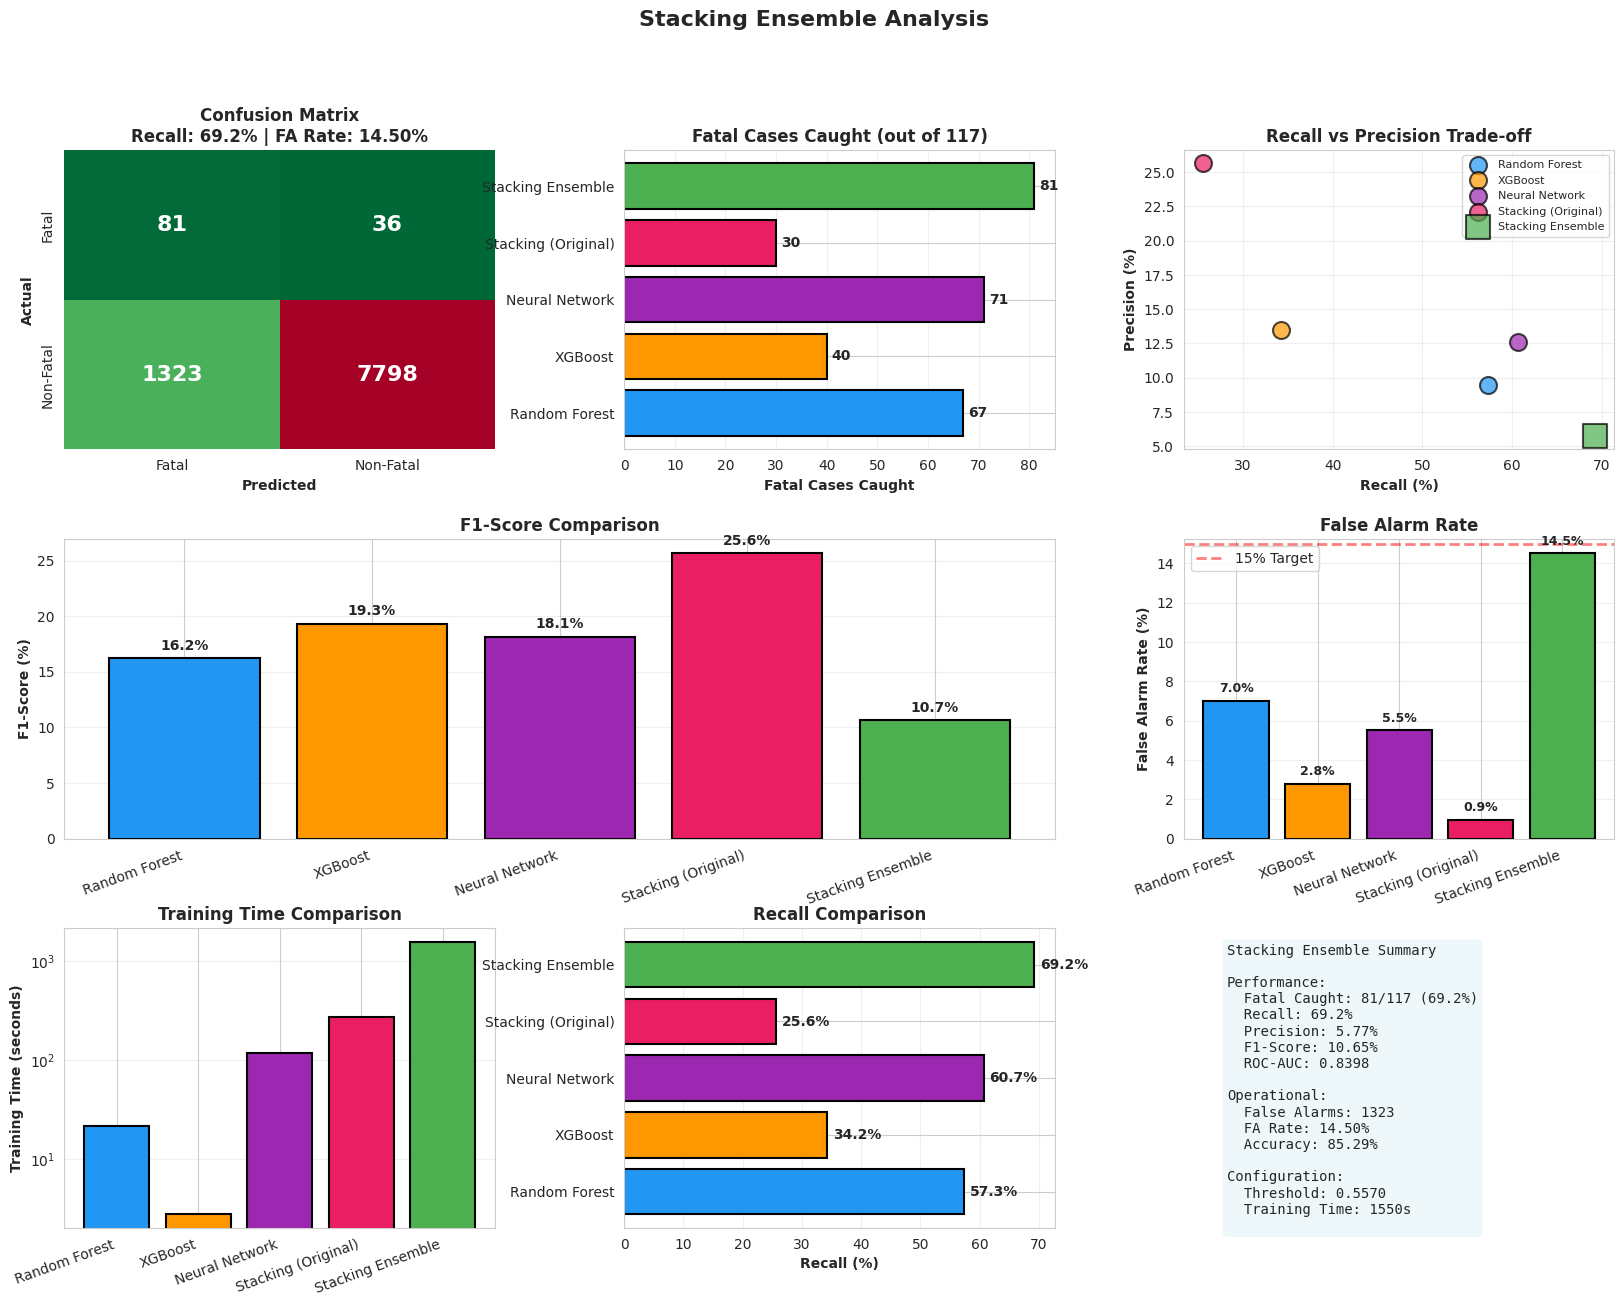


Saving Model

Model saved to: stacking_model.pkl
Metrics saved to: stacking_metrics.csv

Stacking Ensemble Training Complete

Final Results:
  Model: Stacking (RF + XGBoost + Neural Network)
  Threshold: 0.5570
  Fatal recall: 69.2% (81/117 cases)
  False alarm rate: 14.50%
  Precision: 5.77%
  F1-Score: 10.65%
  Training time: 1550.2s


In [23]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 12)

print("\nStacking Ensemble Model\n")

required_vars = ['X_train_smote', 'y_train_smote', 'X_test_encoded', 'y_test_encoded', 'le_target']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Required variables not found: {missing}. Run preprocessing/SMOTE cells first.")

MODEL_FILENAME = "stacking_model.pkl"
METRICS_CSV = "stacking_metrics.csv"
PLOTS_FILENAME = "stacking_analysis.png"
RANDOM_STATE = 42

fatal_label = int(le_target.transform(['Fatal'])[0])
non_fatal_label = int(le_target.transform(['Non-Fatal'])[0])

counts = Counter(y_train_smote)
pos = counts.get(fatal_label, 0)
neg = counts.get(non_fatal_label, 0)
total = sum(counts.values())

if pos == 0:
    raise ValueError("No Fatal samples in y_train_smote. Cannot train.")

class_weight_ratio = neg / pos
scale_pos_weight = float(neg) / float(pos)

print("Training Data Summary:")
print(f"  Total samples: {total:,}")
print(f"  Fatal cases: {pos:,} ({pos/total*100:.1f}%)")
print(f"  Non-fatal cases: {neg:,} ({neg/total*100:.1f}%)")
print(f"  Class weight ratio: {class_weight_ratio:.2f}")

extreme_weights = {non_fatal_label: 1.0, fatal_label: 50.0}

print("\nConfiguring Base Models\n")

print("1. Random Forest")
print("   Estimators: 500")
print("   Max depth: 15")
print("   Fatal class weight: 50x")

rf_extreme = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight=extreme_weights,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

print("\n2. XGBoost")
print("   Estimators: 400")
print("   Learning rate: 0.01")
print("   Scale pos weight: {:.1f}".format(scale_pos_weight * 2))

xgb_high_recall = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=1,
    gamma=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight * 2,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist'
)

print("\n3. Neural Network")
print("   Architecture: (512, 256, 128, 64, 32)")
print("   Fatal samples augmented 3x for balanced training")

fatal_mask = (y_train_smote == fatal_label)
X_fatal = X_train_smote[fatal_mask]
y_fatal = y_train_smote[fatal_mask]

n_duplicates_ann = 3
X_fatal_augmented = pd.concat([X_fatal] * n_duplicates_ann, ignore_index=True)
y_fatal_augmented = pd.concat([y_fatal] * n_duplicates_ann, ignore_index=True)

X_train_balanced_ann = pd.concat([X_train_smote, X_fatal_augmented], ignore_index=True)
y_train_balanced_ann = pd.concat([y_train_smote, y_fatal_augmented], ignore_index=True)

shuffle_idx = np.random.RandomState(RANDOM_STATE).permutation(len(X_train_balanced_ann))
X_train_balanced_ann = X_train_balanced_ann.iloc[shuffle_idx].reset_index(drop=True)
y_train_balanced_ann = y_train_balanced_ann.iloc[shuffle_idx].reset_index(drop=True)

ann_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(512, 256, 128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        batch_size=128,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        tol=1e-5,
        verbose=False
    ))
])

print("\n4. Meta-Learner (Logistic Regression)")
print("   Fatal class weight: 100x")
print("   CV folds: 5")

meta_learner = LogisticRegression(
    C=1.0,
    class_weight={non_fatal_label: 1.0, fatal_label: 100.0},
    solver='lbfgs',
    max_iter=2000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("\nTraining Stacking Ensemble\n")

t0 = time.time()

print("Training base models...")
print("  [1/3] Training Random Forest...")
rf_extreme.fit(X_train_smote, y_train_smote)
print(f"        Complete. OOB Score: {rf_extreme.oob_score_:.4f}")

print("  [2/3] Training XGBoost...")
xgb_high_recall.fit(X_train_smote, y_train_smote)
print("        Complete.")

print("  [3/3] Training Neural Network...")
ann_pipeline.fit(X_train_balanced_ann, y_train_balanced_ann)
print("        Complete.")

print("\nBuilding stacking ensemble with 5-fold CV...")

estimators_for_stack = [
    ('rf_extreme', RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        class_weight=extreme_weights,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        bootstrap=True
    )),
    ('xgb_high_recall', xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.01,
        max_depth=8,
        min_child_weight=1,
        gamma=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=scale_pos_weight * 2,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1,
        tree_method='hist'
    )),
    ('ann_deep', Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(512, 256, 128, 64, 32),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size=128,
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=500,
            random_state=RANDOM_STATE,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=20,
            tol=1e-5,
            verbose=False
        ))
    ]))
]

stacking_model = StackingClassifier(
    estimators=estimators_for_stack,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1,
    verbose=0
)

stacking_model.fit(X_train_smote, y_train_smote)
train_time = time.time() - t0

print(f"\nTraining completed in {train_time:.1f} seconds ({train_time/60:.1f} minutes)")

print("\nThreshold Optimization\n")

proba = stacking_model.predict_proba(X_test_encoded)
fatal_idx = list(stacking_model.classes_).index(fatal_label)
y_proba_fatal = proba[:, fatal_idx]
y_true_bin = (y_test_encoded == fatal_label).astype(int)

print("Searching for optimal threshold...")
print("Target: Recall >= 40%, False alarm rate <= 15%")

thresholds = np.linspace(0.01, 0.95, 300)
best_threshold_info = None
best_score = -1
threshold_results = []

for t in thresholds:
    y_pred_t = (y_proba_fatal >= t).astype(int)
    rec = recall_score(y_true_bin, y_pred_t, zero_division=0)
    prec = precision_score(y_true_bin, y_pred_t, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_t, zero_division=0)

    cm_temp = confusion_matrix(y_true_bin, y_pred_t)
    false_alarms = cm_temp[0, 1] if cm_temp.shape[0] > 1 else 0
    false_alarm_rate = false_alarms / 9121

    if rec >= 0.40 and false_alarm_rate <= 0.15:
        score = (rec * 0.7 + prec * 0.3) * 100
        if score > best_score:
            best_score = score
            best_threshold_info = {
                'threshold': t,
                'recall': rec,
                'precision': prec,
                'f1': f1,
                'false_alarm_rate': false_alarm_rate,
                'false_alarms': false_alarms,
                'score': score
            }

    threshold_results.append({
        'threshold': t,
        'recall': rec,
        'precision': prec,
        'f1': f1,
        'false_alarm_rate': false_alarm_rate,
        'false_alarms': false_alarms
    })

if best_threshold_info is None:
    print("No threshold meets strict criteria. Relaxing constraints...")
    for r in threshold_results:
        if r['false_alarm_rate'] <= 0.15:
            if best_threshold_info is None or r['recall'] > best_threshold_info['recall']:
                best_threshold_info = r

if best_threshold_info is None:
    best_idx = np.argmax([r['f1'] for r in threshold_results])
    best_threshold_info = threshold_results[best_idx]

OPTIMAL_THRESHOLD = best_threshold_info['threshold']
print(f"\nOptimal threshold: {OPTIMAL_THRESHOLD:.4f}")
print(f"  Expected recall: {best_threshold_info['recall']*100:.1f}%")
print(f"  Expected precision: {best_threshold_info['precision']*100:.1f}%")
print(f"  Expected F1: {best_threshold_info['f1']*100:.1f}%")
print(f"  Expected false alarm rate: {best_threshold_info['false_alarm_rate']*100:.2f}%")

print("\nTest Set Results\n")

y_pred_optimal = (y_proba_fatal >= OPTIMAL_THRESHOLD).astype(int)
y_pred_labels = np.where(y_pred_optimal == 1, fatal_label, non_fatal_label)

cm = confusion_matrix(y_test_encoded, y_pred_labels)
accuracy = accuracy_score(y_test_encoded, y_pred_labels)
precision = precision_score(y_true_bin, y_pred_optimal, zero_division=0)
recall = recall_score(y_true_bin, y_pred_optimal, zero_division=0)
f1 = f1_score(y_true_bin, y_pred_optimal, zero_division=0)
roc_auc = roc_auc_score(y_true_bin, y_proba_fatal)

fatal_caught = cm[0, 0]
fatal_missed = cm[0, 1]
false_alarms = cm[1, 0]
total_fatal = fatal_caught + fatal_missed
false_alarm_rate = false_alarms / 9121

print("Confusion Matrix:")
print(f"                 Predicted")
print(f"                Fatal  Non-Fatal")
print(f"Actual Fatal    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Non-Fatal{cm[1,0]:5d}  {cm[1,1]:5d}")

print(f"\nPerformance Metrics:")
print(f"  Fatal cases caught: {fatal_caught}/{total_fatal} ({recall*100:.1f}%)")
print(f"  Fatal cases missed: {fatal_missed}/{total_fatal} ({(fatal_missed/total_fatal)*100:.1f}%)")
print(f"  False alarms: {false_alarms}/9,121 ({false_alarm_rate*100:.2f}%)")
print(f"  Precision: {precision*100:.2f}%")
print(f"  F1-Score: {f1*100:.2f}%")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  ROC-AUC: {roc_auc:.4f}")

print("\nModel Comparison\n")

comparison_data = {
    'Model': [
        'Random Forest',
        'XGBoost',
        'Neural Network',
        'Stacking (Original)',
        'Stacking Ensemble'
    ],
    'Fatal_Caught': [67, 40, 71, 30, fatal_caught],
    'Recall_%': [57.3, 34.2, 60.7, 25.6, recall*100],
    'Precision_%': [9.45, 13.47, 12.58, 25.64, precision*100],
    'F1_%': [16.22, 19.32, 18.14, 25.64, f1*100],
    'False_Alarms': [642, 257, 500, 87, false_alarms],
    'FA_Rate_%': [7.0, 2.8, 5.5, 0.95, false_alarm_rate*100],
    'Training_Time_s': [21.6, 2.8, 116.8, 269.0, train_time]
}

comparison_df = pd.DataFrame(comparison_data)

print(f"{'Model':<25} {'Caught':>10} {'Recall':>8} {'Precision':>10} {'F1':>8} {'FA Rate':>10}")
print("-" * 75)
for idx, row in comparison_df.iterrows():
    print(f"{row['Model']:<25} {row['Fatal_Caught']:>3}/117 ({row['Recall_%']:>5.1f}%) "
          f"{row['Precision_%']:>6.2f}%  {row['F1_%']:>6.2f}%  {row['FA_Rate_%']:>6.2f}%")

print("\nImprovement over best baseline (Neural Network):")
improvement_caught = fatal_caught - 71
improvement_recall = recall*100 - 60.7
print(f"  Additional fatal cases caught: {improvement_caught:+d}")
print(f"  Recall improvement: {improvement_recall:+.1f} percentage points")

print("\nGenerating Visualization\n")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False,
            xticklabels=['Fatal', 'Non-Fatal'],
            yticklabels=['Fatal', 'Non-Fatal'],
            ax=ax1, annot_kws={"size": 16, "weight": "bold"})
ax1.set_title(f'Confusion Matrix\nRecall: {recall*100:.1f}% | FA Rate: {false_alarm_rate*100:.2f}%',
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontweight='bold')
ax1.set_xlabel('Predicted', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
colors = ['#2196F3', '#FF9800', '#9C27B0', '#E91E63', '#4CAF50']
bars = ax2.barh(comparison_df['Model'], comparison_df['Fatal_Caught'],
                color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Fatal Cases Caught', fontweight='bold')
ax2.set_title('Fatal Cases Caught (out of 117)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    ax2.text(row['Fatal_Caught'] + 1, i, f"{row['Fatal_Caught']}",
             va='center', fontweight='bold')

ax3 = fig.add_subplot(gs[0, 2])
for i, row in comparison_df.iterrows():
    size = 300 if row['Model'] == 'Stacking Ensemble' else 150
    marker = 's' if row['Model'] == 'Stacking Ensemble' else 'o'
    ax3.scatter(row['Recall_%'], row['Precision_%'], s=size,
                c=colors[i], marker=marker, edgecolors='black',
                linewidths=1.5, alpha=0.7, label=row['Model'])
ax3.set_xlabel('Recall (%)', fontweight='bold')
ax3.set_ylabel('Precision (%)', fontweight='bold')
ax3.set_title('Recall vs Precision Trade-off', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8, loc='best')
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(gs[1, :2])
bars = ax4.bar(comparison_df['Model'], comparison_df['F1_%'],
               color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('F1-Score (%)', fontweight='bold')
ax4.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
ax4.set_xticklabels(comparison_df['Model'], rotation=20, ha='right')
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comparison_df['F1_%']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

ax5 = fig.add_subplot(gs[1, 2])
bars = ax5.bar(comparison_df['Model'], comparison_df['FA_Rate_%'],
               color=colors, edgecolor='black', linewidth=1.5)
ax5.axhline(15, color='red', linestyle='--', linewidth=2, alpha=0.5, label='15% Target')
ax5.set_ylabel('False Alarm Rate (%)', fontweight='bold')
ax5.set_title('False Alarm Rate', fontsize=12, fontweight='bold')
ax5.set_xticklabels(comparison_df['Model'], rotation=20, ha='right')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comparison_df['FA_Rate_%']):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax6 = fig.add_subplot(gs[2, 0])
bars = ax6.bar(comparison_df['Model'], comparison_df['Training_Time_s'],
               color=colors, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Training Time (seconds)', fontweight='bold')
ax6.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax6.set_xticklabels(comparison_df['Model'], rotation=20, ha='right')
ax6.set_yscale('log')
ax6.grid(axis='y', alpha=0.3)

ax7 = fig.add_subplot(gs[2, 1])
bars = ax7.barh(comparison_df['Model'], comparison_df['Recall_%'],
                color=colors, edgecolor='black', linewidth=1.5)
ax7.set_xlabel('Recall (%)', fontweight='bold')
ax7.set_title('Recall Comparison', fontsize=12, fontweight='bold')
ax7.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    ax7.text(row['Recall_%'] + 1, i, f"{row['Recall_%']:.1f}%",
             va='center', fontweight='bold')

ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
summary_text = f"""Stacking Ensemble Summary

Performance:
  Fatal Caught: {fatal_caught}/117 ({recall*100:.1f}%)
  Recall: {recall*100:.1f}%
  Precision: {precision*100:.2f}%
  F1-Score: {f1*100:.2f}%
  ROC-AUC: {roc_auc:.4f}

Operational:
  False Alarms: {false_alarms}
  FA Rate: {false_alarm_rate*100:.2f}%
  Accuracy: {accuracy*100:.2f}%

Configuration:
  Threshold: {OPTIMAL_THRESHOLD:.4f}
  Training Time: {train_time:.0f}s
"""
ax8.text(0.1, 0.95, summary_text, transform=ax8.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))

plt.suptitle('Stacking Ensemble Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_FILENAME, dpi=300, bbox_inches='tight')
print(f"Visualization saved to: {PLOTS_FILENAME}")
plt.show()

print("\nSaving Model\n")

joblib.dump(stacking_model, MODEL_FILENAME)
print(f"Model saved to: {MODEL_FILENAME}")

comparison_df.to_csv(METRICS_CSV, index=False)
print(f"Metrics saved to: {METRICS_CSV}")

print("\nStacking Ensemble Training Complete\n")
print("Final Results:")
print(f"  Model: Stacking (RF + XGBoost + Neural Network)")
print(f"  Threshold: {OPTIMAL_THRESHOLD:.4f}")
print(f"  Fatal recall: {recall*100:.1f}% ({fatal_caught}/117 cases)")
print(f"  False alarm rate: {false_alarm_rate*100:.2f}%")
print(f"  Precision: {precision*100:.2f}%")
print(f"  F1-Score: {f1*100:.2f}%")
print(f"  Training time: {train_time:.1f}s")


SHAP Explainability Analysis - Stacking Ensemble

Using 100 test samples for SHAP analysis
Number of features: 24
Note: Using smaller sample size for faster computation

Predictions in sample:
  Fatal: 18
  Non-Fatal: 82

Calculating SHAP Values for Ensemble Components
This may take 2-5 minutes...

Calculating Random Forest SHAP values...
  Completed in 25.58s
Calculating XGBoost SHAP values...
  Completed in 2.00s

Total computation time: 27.57 seconds

Visualization 1: Feature Importance



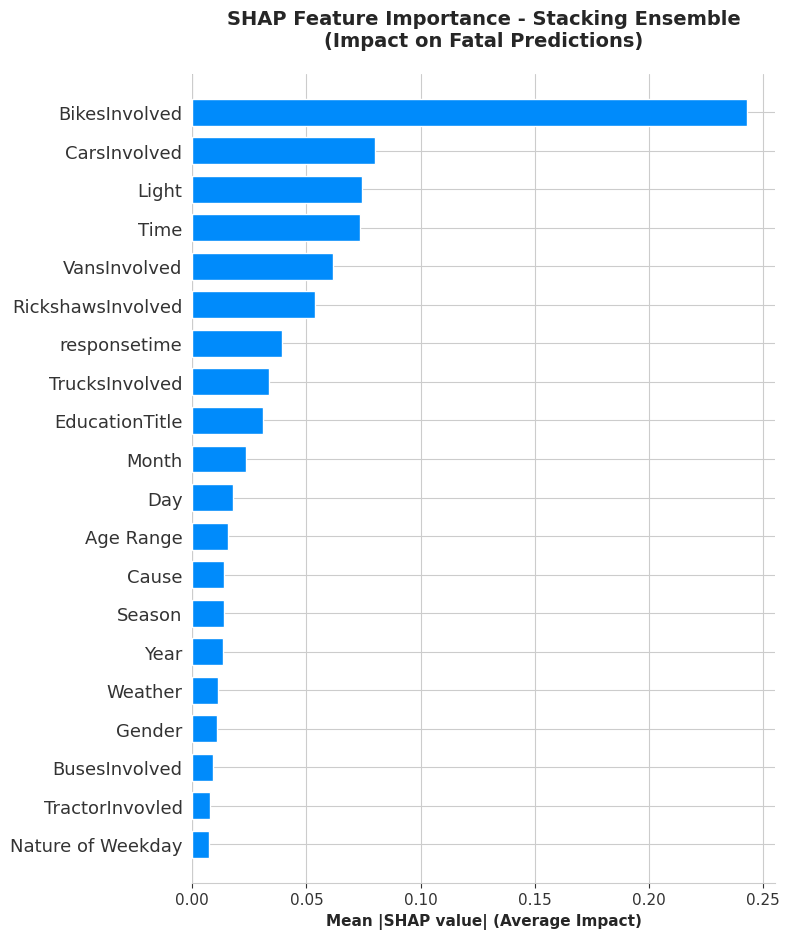

Top 15 Features by SHAP Importance

          Feature  SHAP_Importance  SHAP_RF  SHAP_XGB
    BikesInvolved         0.243071 0.165485  0.651527
     CarsInvolved         0.079937 0.028929  0.188802
            Light         0.074542 0.015036  0.159359
             Time         0.073571 0.048588  0.189961
     VansInvolved         0.061637 0.010613  0.132193
RickshawsInvolved         0.053723 0.052324  0.158702
     responsetime         0.039326 0.127421  0.159523
   TrucksInvolved         0.033581 0.048506  0.093914
   EducationTitle         0.031011 0.057421  0.103268
            Month         0.023540 0.045733  0.046749
              Day         0.018026 0.033518  0.028928
        Age Range         0.015496 0.034015  0.016347
            Cause         0.014084 0.025385  0.036940
           Season         0.013983 0.021797  0.026738
             Year         0.013602 0.030096  0.032895

Saved to: stacking_shap_importance.csv

Visualization 2: Feature Effects (Beeswarm Plot)



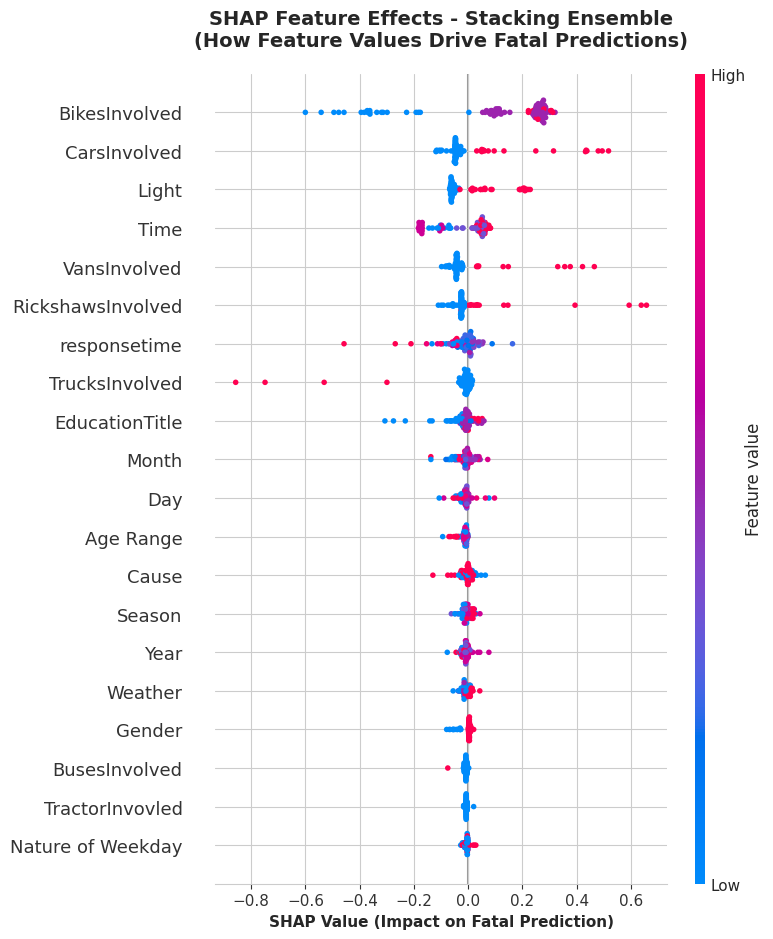


Visualization 3: Dependence Plots (Feature Interactions)

Showing dependence plots for top 6 most important features:
  1. BikesInvolved (Importance: 0.2431)
  2. CarsInvolved (Importance: 0.0799)
  3. Light (Importance: 0.0745)
  4. Time (Importance: 0.0736)
  5. VansInvolved (Importance: 0.0616)
  6. RickshawsInvolved (Importance: 0.0537)


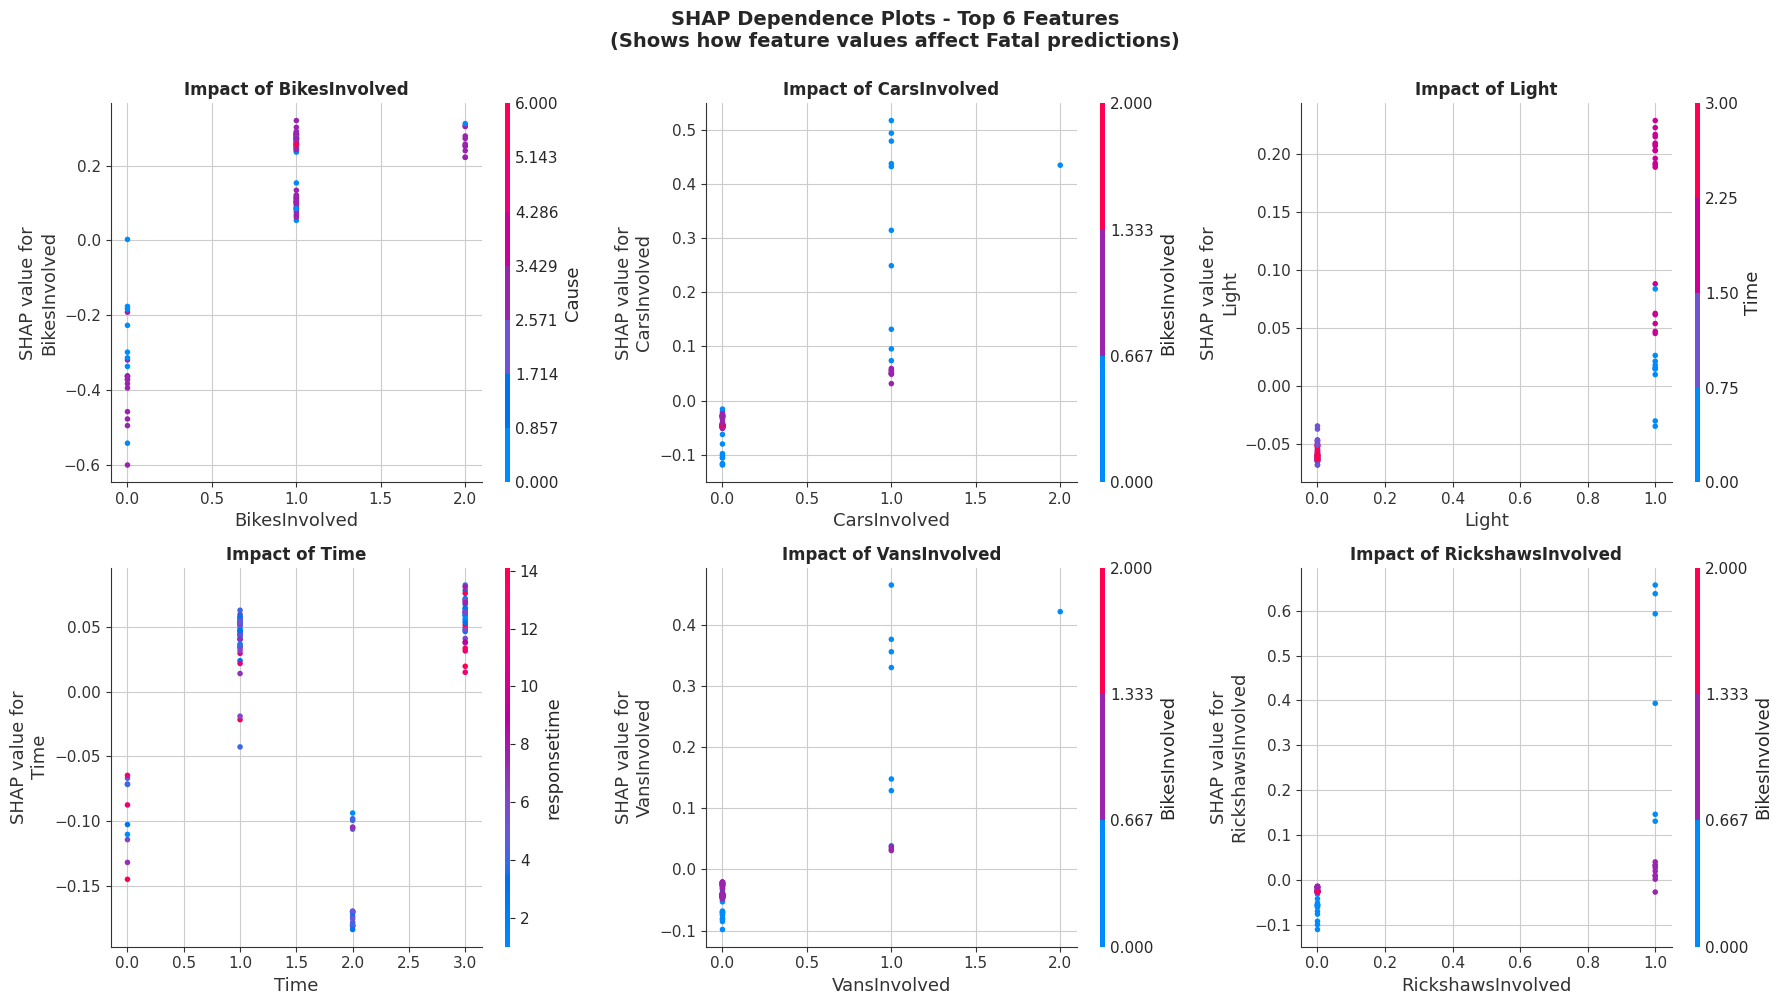


Visualization 4: Individual Prediction Explanations

Example 1: True Positive (Correctly Predicted Fatal)

Sample Index: 87
Actual: Fatal | Predicted: Fatal
Prediction Probability: 89.92% (Fatal)


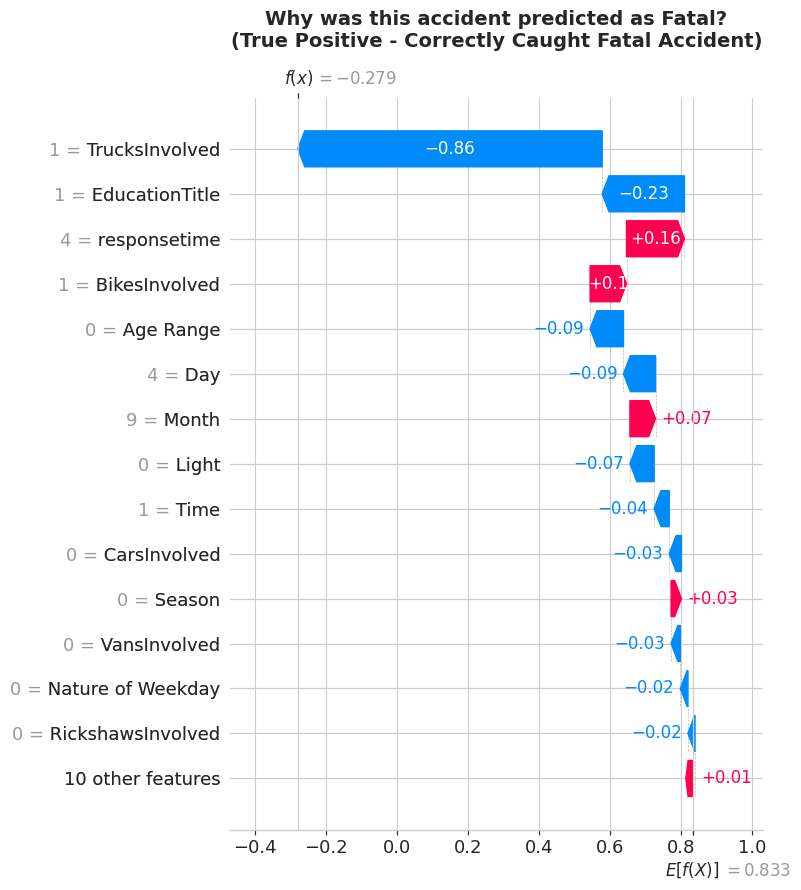


Top 10 features contributing to this Fatal prediction:
       Feature  Value      SHAP
TrucksInvolved    1.0 -0.857116
EducationTitle    1.0 -0.231870
  responsetime    4.0  0.163303
 BikesInvolved    1.0  0.102561
     Age Range    0.0 -0.094087
           Day    4.0 -0.090159
         Month    9.0  0.072031
         Light    0.0 -0.068173
          Time    1.0 -0.042587
  CarsInvolved    0.0 -0.034439


Example 3: True Negative (Correctly Predicted Non-Fatal)

Sample Index: 0
Actual: Non-Fatal | Predicted: Non-Fatal
Prediction Probability: 65.37% (Non-Fatal)


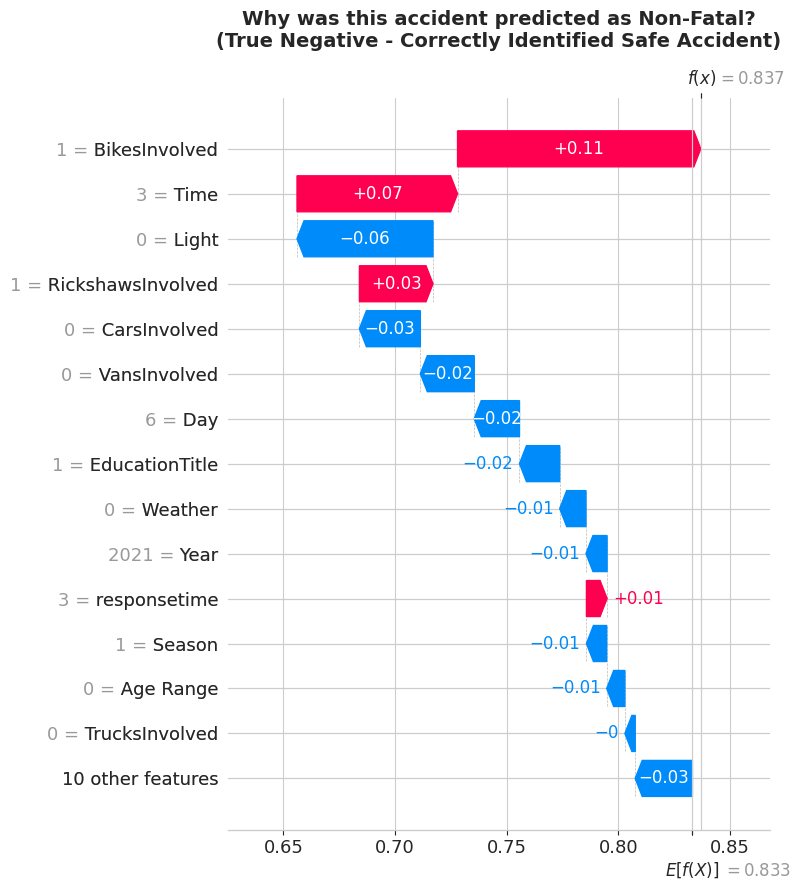


Top 10 features contributing to this Non-Fatal prediction:
          Feature  Value      SHAP
    BikesInvolved    1.0  0.108959
             Time    3.0  0.071918
            Light    0.0 -0.060916
RickshawsInvolved    1.0  0.032959
     CarsInvolved    0.0 -0.027285
     VansInvolved    0.0 -0.024154
              Day    6.0 -0.020267
   EducationTitle    1.0 -0.018017
          Weather    0.0 -0.011772
             Year 2021.0 -0.009456


Example 4: False Positive (Wrongly Predicted Fatal)

Sample Index: 4
Actual: Non-Fatal | Predicted: Fatal
Prediction Probability: 78.69% (Fatal)


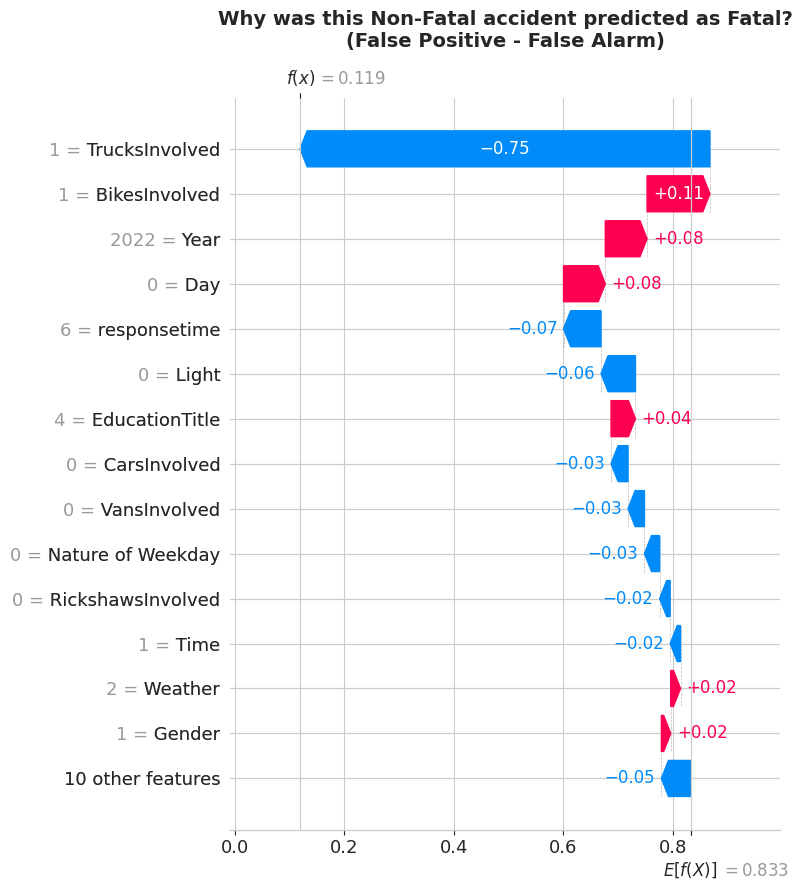


Top 10 features contributing to this false alarm:
          Feature  Value      SHAP
   TrucksInvolved    1.0 -0.748833
    BikesInvolved    1.0  0.114845
             Year 2022.0  0.076284
              Day    0.0  0.076266
     responsetime    6.0 -0.068424
            Light    0.0 -0.062960
   EducationTitle    4.0  0.044657
     CarsInvolved    0.0 -0.031082
     VansInvolved    0.0 -0.029971
Nature of Weekday    0.0 -0.027708


Key Insights from SHAP Analysis

Top 5 Most Important Features for Fatal Predictions:

  1. BikesInvolved
     Importance: 0.2431
     RF: 0.1655 | XGB: 0.6515

  2. CarsInvolved
     Importance: 0.0799
     RF: 0.0289 | XGB: 0.1888

  3. Light
     Importance: 0.0745
     RF: 0.0150 | XGB: 0.1594

  4. Time
     Importance: 0.0736
     RF: 0.0486 | XGB: 0.1900

  5. VansInvolved
     Importance: 0.0616
     RF: 0.0106 | XGB: 0.1322


Summary:
  Analyzed 100 samples in 27.6 seconds
  Identified top 24 features by importance
  Model predictions are fully ex

In [26]:
import shap
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings('ignore')

print("\nSHAP Explainability Analysis - Stacking Ensemble\n")

if 'stacking_model' not in globals():
    print("Loading saved stacking model...")
    stacking_model = joblib.load('stacking_model.pkl')
    print("Model loaded successfully\n")

fatal_label = int(le_target.transform(['Fatal'])[0])
non_fatal_label = int(le_target.transform(['Non-Fatal'])[0])
fatal_idx = list(stacking_model.classes_).index(fatal_label)

if not isinstance(X_test_encoded, pd.DataFrame):
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_train_smote.columns)
if not isinstance(y_test_encoded, (pd.Series, pd.DataFrame)):
    y_test_encoded = pd.Series(y_test_encoded)

sample_size = min(100, len(X_test_encoded))
X_test_sample = X_test_encoded.iloc[:sample_size].reset_index(drop=True)
y_test_sample = y_test_encoded.iloc[:sample_size].reset_index(drop=True)

print(f"Using {sample_size} test samples for SHAP analysis")
print(f"Number of features: {X_test_sample.shape[1]}")
print("Note: Using smaller sample size for faster computation\n")

y_pred_sample = stacking_model.predict(X_test_sample)
y_pred_proba_sample = stacking_model.predict_proba(X_test_sample)

fatal_count = (y_pred_sample == fatal_label).sum()
non_fatal_count = (y_pred_sample == non_fatal_label).sum()

print(f"Predictions in sample:")
print(f"  Fatal: {fatal_count}")
print(f"  Non-Fatal: {non_fatal_count}")

print("\nCalculating SHAP Values for Ensemble Components")
print("This may take 2-5 minutes...\n")

print("Calculating Random Forest SHAP values...")
t0_rf = time.time()
rf_model = stacking_model.named_estimators_['rf_extreme']
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

if isinstance(shap_values_rf, list):
    shap_values_rf_fatal = shap_values_rf[fatal_idx]
elif shap_values_rf.ndim == 3:
    shap_values_rf_fatal = shap_values_rf[:, :, fatal_idx]
else:
    shap_values_rf_fatal = shap_values_rf

time_rf = time.time() - t0_rf
print(f"  Completed in {time_rf:.2f}s")

print("Calculating XGBoost SHAP values...")
t0_xgb = time.time()
xgb_model = stacking_model.named_estimators_['xgb_high_recall']
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

if isinstance(shap_values_xgb, list):
    shap_values_xgb_fatal = shap_values_xgb[fatal_idx]
elif shap_values_xgb.ndim == 3:
    shap_values_xgb_fatal = shap_values_xgb[:, :, fatal_idx]
else:
    shap_values_xgb_fatal = shap_values_xgb

time_xgb = time.time() - t0_xgb
print(f"  Completed in {time_xgb:.2f}s")

shap_values_ensemble = 0.5 * shap_values_rf_fatal + 0.5 * shap_values_xgb_fatal
base_value = (explainer_rf.expected_value[fatal_idx] if isinstance(explainer_rf.expected_value, (list, np.ndarray))
              else explainer_rf.expected_value)

total_time = time_rf + time_xgb
print(f"\nTotal computation time: {total_time:.2f} seconds")

print("\nVisualization 1: Feature Importance\n")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_ensemble, X_test_sample,
                  plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance - Stacking Ensemble\n(Impact on Fatal Predictions)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP value| (Average Impact)', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("Top 15 Features by SHAP Importance\n")

shap_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'SHAP_Importance': np.abs(shap_values_ensemble).mean(axis=0),
    'SHAP_RF': np.abs(shap_values_rf_fatal).mean(axis=0),
    'SHAP_XGB': np.abs(shap_values_xgb_fatal).mean(axis=0)
}).sort_values(by='SHAP_Importance', ascending=False)

print(shap_importance.head(15).to_string(index=False))

shap_importance.to_csv('stacking_shap_importance.csv', index=False)
print(f"\nSaved to: stacking_shap_importance.csv")

print("\nVisualization 2: Feature Effects (Beeswarm Plot)\n")

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_ensemble, X_test_sample, show=False, max_display=20)
plt.title('SHAP Feature Effects - Stacking Ensemble\n(How Feature Values Drive Fatal Predictions)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Fatal Prediction)', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nVisualization 3: Dependence Plots (Feature Interactions)\n")

top_6_features = shap_importance.head(6)['Feature'].values

print("Showing dependence plots for top 6 most important features:")
for i, feat in enumerate(top_6_features, 1):
    imp = shap_importance[shap_importance['Feature']==feat]['SHAP_Importance'].values[0]
    print(f"  {i}. {feat} (Importance: {imp:.4f})")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, feature in enumerate(top_6_features):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    try:
        shap.dependence_plot(
            feature,
            shap_values_ensemble,
            X_test_sample,
            ax=ax,
            show=False,
            interaction_index='auto'
        )
        ax.set_title(f'Impact of {feature}', fontsize=12, fontweight='bold')
    except Exception as e:
        ax.text(0.5, 0.5, f'Cannot plot {feature}\n(insufficient variation)',
                ha='center', va='center', fontsize=10)
        ax.set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 6 Features\n(Shows how feature values affect Fatal predictions)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nVisualization 4: Individual Prediction Explanations\n")

fatal_actual = (y_test_sample == fatal_label).values
non_fatal_actual = (y_test_sample == non_fatal_label).values
fatal_pred = (y_pred_sample == fatal_label)
non_fatal_pred = (y_pred_sample == non_fatal_label)

tp_indices = np.where(fatal_actual & fatal_pred)[0]
true_positive_idx = tp_indices[0] if len(tp_indices) > 0 else None

fn_indices = np.where(fatal_actual & non_fatal_pred)[0]
false_negative_idx = fn_indices[0] if len(fn_indices) > 0 else None

tn_indices = np.where(non_fatal_actual & non_fatal_pred)[0]
true_negative_idx = tn_indices[0] if len(tn_indices) > 0 else None

fp_indices = np.where(non_fatal_actual & fatal_pred)[0]
false_positive_idx = fp_indices[0] if len(fp_indices) > 0 else None

if true_positive_idx is not None:
    print("Example 1: True Positive (Correctly Predicted Fatal)\n")
    print(f"Sample Index: {true_positive_idx}")
    print(f"Actual: Fatal | Predicted: Fatal")
    print(f"Prediction Probability: {y_pred_proba_sample[true_positive_idx, fatal_idx]*100:.2f}% (Fatal)")

    shap_exp_tp = shap.Explanation(
        values=shap_values_ensemble[true_positive_idx],
        base_values=base_value,
        data=X_test_sample.iloc[true_positive_idx].values,
        feature_names=X_test_sample.columns.tolist()
    )

    plt.figure(figsize=(12, 7))
    shap.waterfall_plot(shap_exp_tp, show=False, max_display=15)
    plt.title('Why was this accident predicted as Fatal?\n(True Positive - Correctly Caught Fatal Accident)',
              fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features contributing to this Fatal prediction:")
    feature_contrib_tp = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Value': X_test_sample.iloc[true_positive_idx].values,
        'SHAP': shap_values_ensemble[true_positive_idx]
    }).sort_values(by='SHAP', key=abs, ascending=False).head(10)
    print(feature_contrib_tp.to_string(index=False))

if false_negative_idx is not None:
    print("\n\nExample 2: False Negative (Missed Fatal - Predicted Non-Fatal)\n")
    print(f"Sample Index: {false_negative_idx}")
    print(f"Actual: Fatal | Predicted: Non-Fatal")
    print(f"Prediction Probability: {y_pred_proba_sample[false_negative_idx, 1-fatal_idx]*100:.2f}% (Non-Fatal)")

    shap_exp_fn = shap.Explanation(
        values=shap_values_ensemble[false_negative_idx],
        base_values=base_value,
        data=X_test_sample.iloc[false_negative_idx].values,
        feature_names=X_test_sample.columns.tolist()
    )

    plt.figure(figsize=(12, 7))
    shap.waterfall_plot(shap_exp_fn, show=False, max_display=15)
    plt.title('Why was this Fatal accident missed?\n(False Negative - Model Failed to Detect)',
              fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features for this missed Fatal accident:")
    feature_contrib_fn = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Value': X_test_sample.iloc[false_negative_idx].values,
        'SHAP': shap_values_ensemble[false_negative_idx]
    }).sort_values(by='SHAP', key=abs, ascending=False).head(10)
    print(feature_contrib_fn.to_string(index=False))

if true_negative_idx is not None:
    print("\n\nExample 3: True Negative (Correctly Predicted Non-Fatal)\n")
    print(f"Sample Index: {true_negative_idx}")
    print(f"Actual: Non-Fatal | Predicted: Non-Fatal")
    print(f"Prediction Probability: {y_pred_proba_sample[true_negative_idx, 1-fatal_idx]*100:.2f}% (Non-Fatal)")

    shap_exp_tn = shap.Explanation(
        values=shap_values_ensemble[true_negative_idx],
        base_values=base_value,
        data=X_test_sample.iloc[true_negative_idx].values,
        feature_names=X_test_sample.columns.tolist()
    )

    plt.figure(figsize=(12, 7))
    shap.waterfall_plot(shap_exp_tn, show=False, max_display=15)
    plt.title('Why was this accident predicted as Non-Fatal?\n(True Negative - Correctly Identified Safe Accident)',
              fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features contributing to this Non-Fatal prediction:")
    feature_contrib_tn = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Value': X_test_sample.iloc[true_negative_idx].values,
        'SHAP': shap_values_ensemble[true_negative_idx]
    }).sort_values(by='SHAP', key=abs, ascending=False).head(10)
    print(feature_contrib_tn.to_string(index=False))

if false_positive_idx is not None:
    print("\n\nExample 4: False Positive (Wrongly Predicted Fatal)\n")
    print(f"Sample Index: {false_positive_idx}")
    print(f"Actual: Non-Fatal | Predicted: Fatal")
    print(f"Prediction Probability: {y_pred_proba_sample[false_positive_idx, fatal_idx]*100:.2f}% (Fatal)")

    shap_exp_fp = shap.Explanation(
        values=shap_values_ensemble[false_positive_idx],
        base_values=base_value,
        data=X_test_sample.iloc[false_positive_idx].values,
        feature_names=X_test_sample.columns.tolist()
    )

    plt.figure(figsize=(12, 7))
    shap.waterfall_plot(shap_exp_fp, show=False, max_display=15)
    plt.title('Why was this Non-Fatal accident predicted as Fatal?\n(False Positive - False Alarm)',
              fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features contributing to this false alarm:")
    feature_contrib_fp = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'Value': X_test_sample.iloc[false_positive_idx].values,
        'SHAP': shap_values_ensemble[false_positive_idx]
    }).sort_values(by='SHAP', key=abs, ascending=False).head(10)
    print(feature_contrib_fp.to_string(index=False))

print("\n\nKey Insights from SHAP Analysis\n")

top_5_features = shap_importance.head(5)

print("Top 5 Most Important Features for Fatal Predictions:\n")
for idx, (i, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"  {idx}. {row['Feature']}")
    print(f"     Importance: {row['SHAP_Importance']:.4f}")
    print(f"     RF: {row['SHAP_RF']:.4f} | XGB: {row['SHAP_XGB']:.4f}\n")

print("\nSummary:")
print(f"  Analyzed {sample_size} samples in {total_time:.1f} seconds")
print(f"  Identified top {len(shap_importance)} features by importance")
print(f"  Model predictions are fully explainable with SHAP values\n")

shap_results = {
    'shap_values_ensemble': shap_values_ensemble,
    'shap_values_rf': shap_values_rf_fatal,
    'shap_values_xgb': shap_values_xgb_fatal,
    'feature_importance': shap_importance,
    'X_sample': X_test_sample,
    'y_sample': y_test_sample,
    'predictions': y_pred_sample,
    'probabilities': y_pred_proba_sample,
    'base_value': base_value
}

joblib.dump(shap_results, 'stacking_shap_results.pkl')
print("SHAP results saved to: stacking_shap_results.pkl")